<!-- Título principal -->
<p align="center" style="font-size:40px; font-weight:bold;">
  Computational Machine Learning
</p>
<p align="center" style="font-size:30px;">
Position Classification for FC Barcelona's Youth Players
</p>
<!-- Subtítulo de la escuela -->
<p align="center" style="font-size:30px;">
  Barcelona School of Economics
</p>

<!-- Nombre del curso -->
<p align="center" style="font-size:25px;">
  Data Science for Decision Making
</p>

<!-- Lista de miembros -->
<p align="center" style="font-size:20px;">
  <b>Members:</b>
</p>

<p align="center" style="font-size:18px;">
  - Lucia Sauer <br>
  
</p>


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
import numpy as np
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV,StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
sns.set(style="darkgrid")
sns.set_palette("crest")
palette = sns.color_palette("crest", n_colors=30, as_cmap=False)

In [2]:
# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')
# df_train['is_test'] = 0
# df_test['is_test'] = 1
# df = pd.concat([df_train, df_test], ignore_index=True)
df = pd.read_csv('train.csv')
df.head()

id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name  ...  \
0        176         73  Club Atlético de San Luis  ...   
1        183         73             Ross County FC  ...   
2        178         69                  Aarhus GF  ...   
3        188         81          Incheon United FC  ...   
4        179         74                FC Botoşani  ...   

  defending_marking_awareness  defending_standing_tackle  \
0                          65                         66   
1                          65                         61   
2                          60                         58   
3                          16                         22   
4                          64                         61   

   defending_sliding_tackle goalkeeping_diving goalkeeping_handling  \
0                        65                 14                   11   
1                        58                 10                   13   
2                        59                 10                   10   
3                        19                 16                   15   
4                        58                 12                    5   

   goalkeeping_kicking goalkeeping_positioning  goalkeeping_reflexes  \
0                   12                      12                    12   
1                    7                       6                    11   
2                    8                      10                    11   
3                   13                       8                     9   
4                   11                      12                    15   

  goalkeeping_speed  position  
0               NaN        LB  
1               NaN       LDM  
2               NaN       LWB  
3               NaN        LS  
4               NaN        LB  

[5 rows x 70 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6895 entries, 0 to 6894
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6895 non-null   int64  
 1   short_name                   6895 non-null   object 
 2   overall                      6895 non-null   int64  
 3   potential                    6895 non-null   int64  
 4   value_eur                    6893 non-null   float64
 5   wage_eur                     6895 non-null   int64  
 6   birthday_date                6895 non-null   object 
 7   height_cm                    6895 non-null   int64  
 8   weight_kg                    6895 non-null   int64  
 9   club_name                    6895 non-null   object 
 10  league_name                  6895 non-null   object 
 11  league_level                 6895 non-null   int64  
 12  club_jersey_number           6895 non-null   int64  
 13  club_loaned_from  

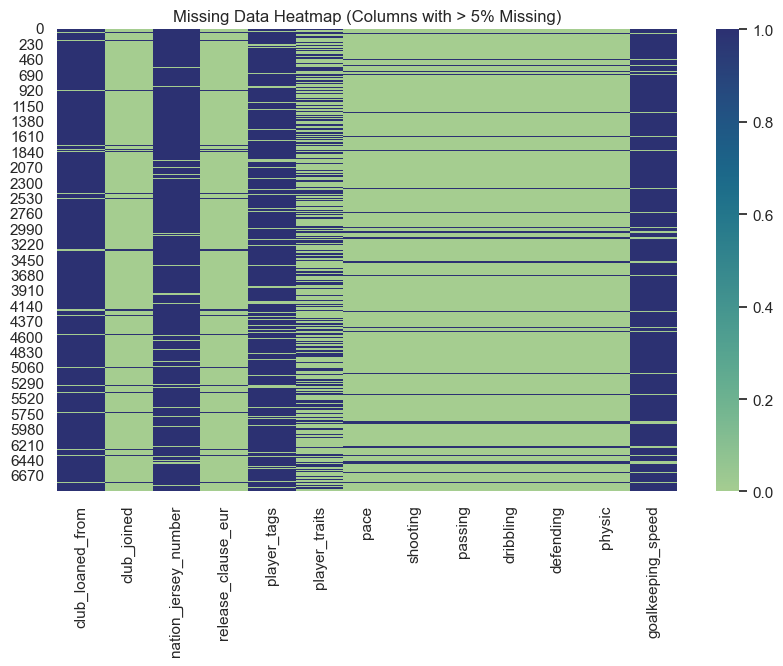

In [4]:
missing_percentage = df.isnull().mean() * 100
columns_above_threshold = missing_percentage[missing_percentage > 5].index
plt.figure(figsize=(10, 6))
sns.heatmap(df[columns_above_threshold].isnull(), cbar=True, cmap="crest")
plt.title('Missing Data Heatmap (Columns with > 5% Missing)')
plt.show()

In [5]:
df.loc[df['goalkeeping_speed'].isna()]['position'].unique()

array(['LB', 'LDM', 'LWB', 'LS', 'RW', 'LCM', 'RM', 'RCM', 'LW', 'LCB',
       'RB', 'RCB', 'CDM', 'RDM', 'CAM', 'CB', 'ST', 'RS', 'LM', 'RWB',
       'LF', 'RF', 'CM'], dtype=object)

- When the column `goalkeeping_speed` is null it is because the positions are not goal keeper, so this column could serve as a dummy variable to identify goal keeper positions.

- We decided to drop columns with a high percentage of null values containing string data because filling them would be highly challenging. Moreover, imputing values for 80% of the dataset is generally not considered good practice. Additionally, in decision tree models, each leaf requires a minimum amount of data; therefore, retaining these columns would likely result in the model discarding them anyway due to the insufficient number of valid data points. The dropped columns are: `player_traits` and `player_tags`.

- Some columns were also excluded based on our intuition that they lack predictive power, such as: `club_loaned_from`, `nation_jersey_number`,`release_clause_eur`, `real_face`.

- For the columns `club_joined`,  `pace`, `shooting`, `passing`, `dribbling`, `defending`, and `physic`, it appears that the null values are concentrated on the same players. As a result, we may consider either imputing these values or dropping the values all together.


In [6]:
df = df.drop(columns=['club_loaned_from', 'nation_jersey_number','release_clause_eur', 'player_tags', 'player_traits', 'real_face'], axis=1)

## **Target Variable: Position**
Analyze how balanced is the predicted variable: position

| **Position**         | **Explanation**                                                                                     |
|----------------------|-----------------------------------------------------------------------------------------------------|
| **GK** (Goalkeeper)   | Guards the goal and prevents opposing teams from scoring.                                          |
| **RCB** (Right Center Back) | Defends the right side of central defense and initiates play.                                         |
| **LCB** (Left Center Back) | Defends the left side of central defense and starts build-up play.                                     |
| **RB** (Right Back)   | Defends the right flank and supports offensive plays.                                               |
| **LB** (Left Back)    | Defends the left flank and supports attacking plays.                                                |
| **ST** (Striker)      | Leads the attack and scores goals.                                                                  |
| **RCM** (Right Center Midfielder) | Plays centrally, balancing offensive and defensive roles from the right.                           |
| **LCM** (Left Center Midfielder) | Plays centrally, balancing offensive and defensive roles from the left.                           |
| **RM** (Right Midfielder) | Plays on the right flank, supporting both attack and defense.                                      |
| **LM** (Left Midfielder) | Plays on the left flank, supporting both attack and defense.                                       |
| **CAM** (Central Attacking Midfielder) | Creates scoring opportunities behind forwards.                                                   |
| **RDM** (Right Defensive Midfielder) | Focuses on defense and distributing the ball from the right.                                      |
| **LS** (Left Striker) | Plays on the left side of the attack, contributing to goals.                                         |
| **RS** (Right Striker) | Plays on the right side of the attack, contributing to goals.                                        |
| **LDM** (Left Defensive Midfielder) | Shields defense and distributes the ball from the left.                                           |
| **CB** (Center Back)  | Defends centrally, maintaining defensive stability.                                                 |
| **RW** (Right Winger) | Plays on the right flank, attacking and crossing the ball.                                           |
| **LW** (Left Winger) | Plays on the left flank, attacking and providing crosses.                                            |
| **CDM** (Central Defensive Midfielder) | Shields defense and starts attacks from the center.                                               |
| **LWB** (Left Wing Back) | Defends and attacks from the left flank, similar to a wing-back.                                      |
| **RWB** (Right Wing Back) | Defends and attacks from the right flank, similar to a wing-back.                                     |
| **CM** (Central Midfielder) | Plays centrally, involved in both attack and defense.                                               |
| **LF** (Left Forward) | Plays forward on the left side, scoring goals and contributing to attacks.                           |
| **RF** (Right Forward) | Plays forward on the right side, scoring goals and contributing to attacks.                          |


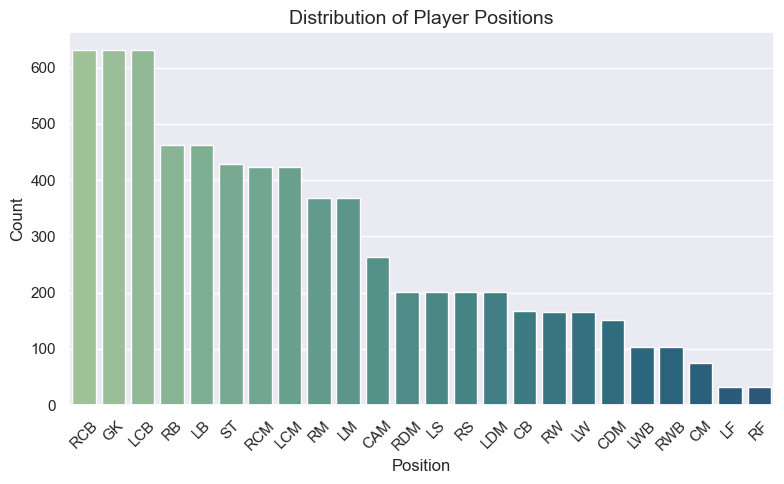

In [7]:
position_counts = df['position'].value_counts().reset_index()
position_counts.columns = ['position', 'count']
plt.figure(figsize=(8, 5))
sns.barplot(data=position_counts,x='position',y='count',palette=palette[:24])
plt.title('Distribution of Player Positions', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- From this plot, we can observe how unbalanced the target variable is. Based on this, it is likely that the model will predominantly predict the first positions: **RCB**, **GK**, and **LCB**.

- The following plot will help us understand where the positions with the most data are located and identify the challenging positions for the model to predict.

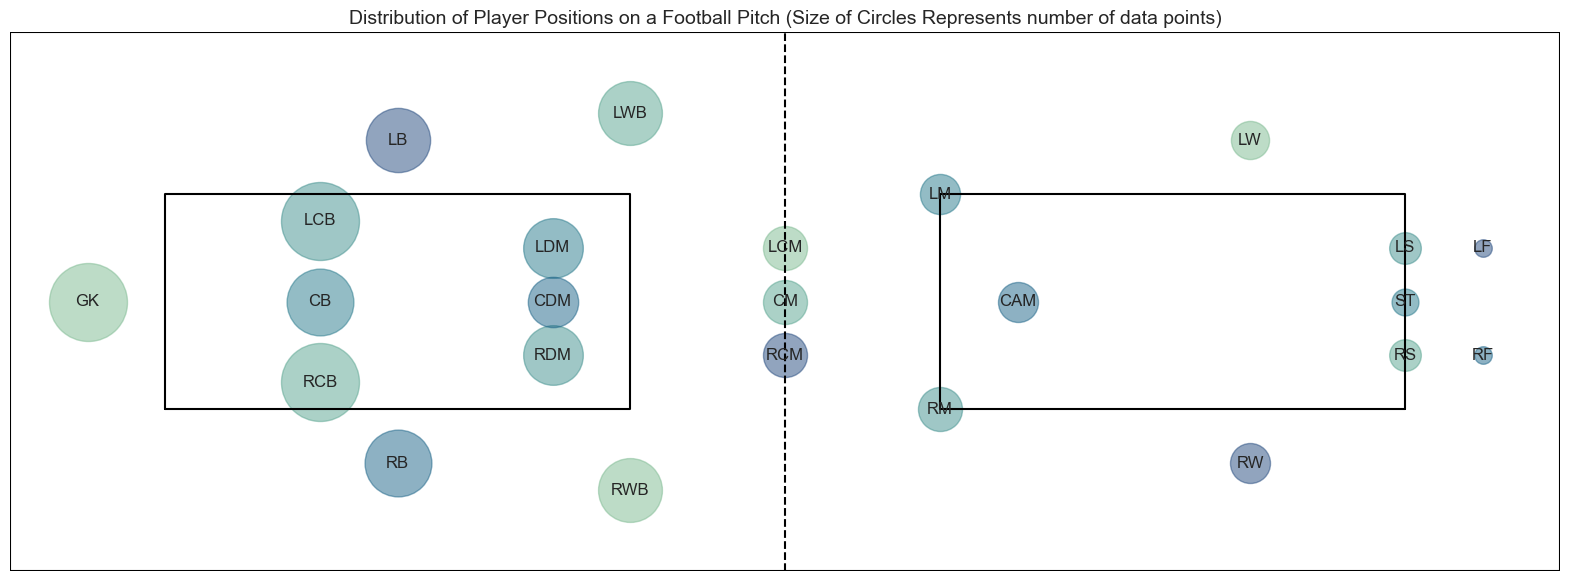

In [8]:
coordinates = {
    'GK': (5, 50), 'RCB': (20, 35), 'LCB': (20, 65), 'CB': (20, 50),
    'RB': (25, 20), 'LB': (25, 80), 'RWB': (40, 15), 'LWB': (40, 85),
    'RDM': (35, 40), 'LDM': (35, 60), 'CDM': (35, 50),
    'RCM': (50, 40), 'LCM': (50, 60), 'CM': (50, 50),
    'RM': (60, 30), 'LM': (60, 70), 'CAM': (65, 50),
    'RW': (80, 20), 'LW': (80, 80),
    'RS': (90, 40), 'LS': (90, 60), 'ST': (90, 50),
    'RF': (95, 40), 'LF': (95, 60)
}
positions = list(coordinates.keys())
counts = position_counts['count'].tolist()
def draw_pitch():
    plt.figure(figsize=(20, 7))
    plt.plot([0, 0, 100, 100, 0], [0, 100, 100, 0, 0], color="black")
    plt.plot([50, 50], [0, 100], color="black", linestyle="--")
    plt.plot([10, 10, 40, 40, 10], [30, 70, 70, 30, 30], color="black")
    plt.plot([90, 90, 60, 60, 90], [30, 70, 70, 30, 30], color="black")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.axis('off')
draw_pitch()
for pos, count in zip(positions, counts):
    x, y = coordinates[pos]
    plt.scatter(x, y, s=count*5, alpha=0.5)
    plt.text(x, y, pos, fontsize=12, ha='center', va='center')
plt.title("Distribution of Player Positions on a Football Pitch (Size of Circles Represents number of data points)", fontsize=14)
plt.show()

- It is clear that the goalkeeper and defensive positions are likely the easiest for the model to detect, as the data is predominantly concentrated in the right half of the field.
- To enhance exploratory data analysis (EDA) and dataset interpretability, two new features were derived from the 'position' column: `subposition` (Attack, Defense, Goalkeeper, Midfielder) and `side` (Left, Right, Center). These groupings simplify analysis and visualization by reducing the complexity of the original 24 unique classes, making it easier to uncover patterns and trends relevant to building predictive models. Also they are gonna be usefull to the final ensemble model we are going to implement.

**`subposition`**

- **Defenders (8 positions)**: RCB, LCB, CB, RB, LB, RWB, LWB
- **Midfielders (7 positions)**: CDM, LDM, RDM, RCM, LCM, CM, CAM
- **Forwards/Attackers (9 positions)**: RW, LW, RS, LS, ST, RF, LF
- **Goal Keeper:**: GK

**`side`**

- **right**: RCB, RB, RWB, RDM, RCM, RW, RS, RF
- **left**: LCB, LB, LWB, LDM, LCM, LW, LS, LF
- **middle**: CB, CDM, CM, CAM, ST, GK


In [9]:
def create_subposition(df):
    with open('subposition.json', 'r') as file:
        subposition_map = json.load(file)
    df['subposition'] = df['position'].map(subposition_map)
    return df
def create_side(df):
    with open('side.json', 'r') as file:
        side_map = json.load(file)
    df['side'] = df['position'].map(side_map)
    return df
df = create_subposition(df)
df = create_side(df)

Check the balance of the `subposition` and `side` classes:

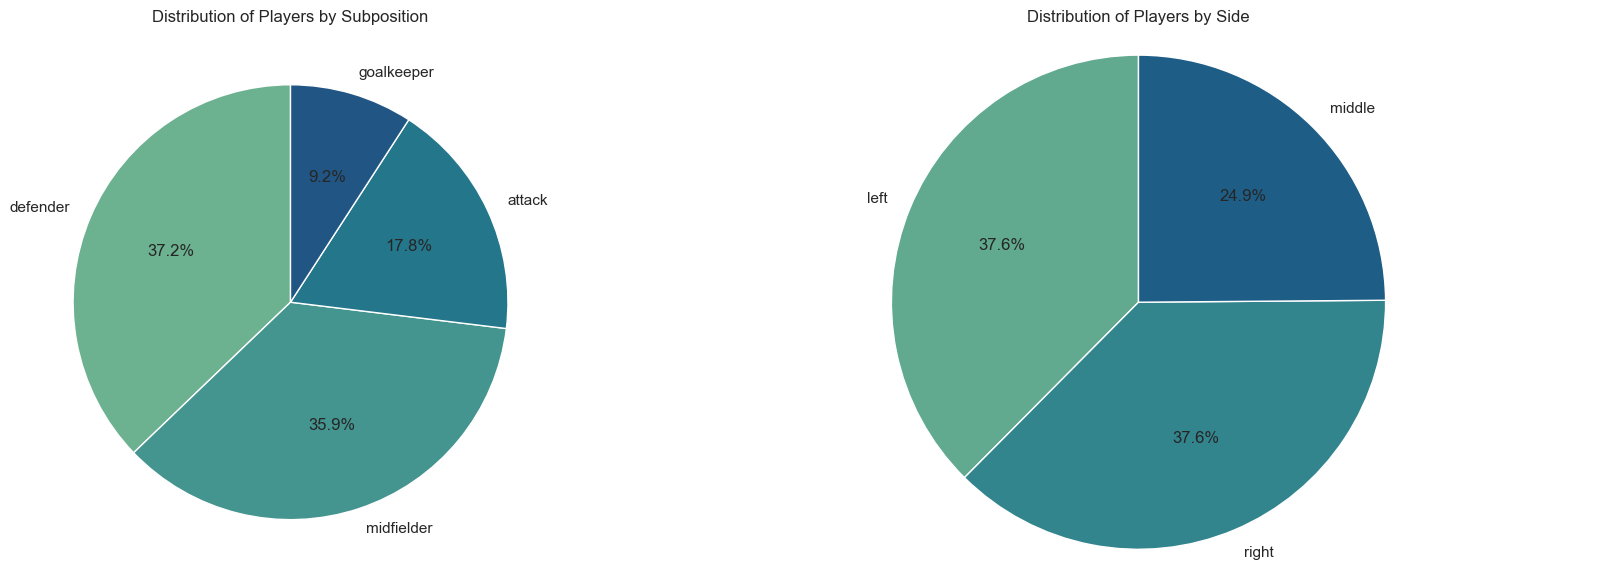

In [10]:
subposition_counts = df['subposition'].value_counts()
side_counts = df['side'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].pie(subposition_counts, labels=subposition_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("crest", n_colors=len(subposition_counts)))
axes[0].set_title('Distribution of Players by Subposition')
axes[1].pie(side_counts, labels=side_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("crest", n_colors=len(side_counts)))
axes[1].set_title('Distribution of Players by Side')
plt.axis('equal')
plt.tight_layout()
plt.show()

## **EDA by features**

The exploratory data analysis (EDA) is organized into sections to examine the distribution of the different attributes and their correlation to players' positions and subpositions.

### 1. **Demographic and Positional Analysis**  

This section explores demographic player characteristics, including their age, nationality and club signing dates, and their distribution across subpositions, and sides. It provides insights into demographic patterns and their relationship with positional attributes.

- **Age distribution by subposition**: Player age could influence experience and role in the position. Are younger positions more related to offensive (attackers) or defensive roles?

- **Experience distribution by subposition**: Some players with more experience may be more associated with certain positions due to their tactical understanding, leadership skills, and ability to perform under pressure, which are often more critical in specific roles like defenders or midfielders compared to others.

- **Nationality distribution**: A player’s nationality may reflect the footballing culture and style of play of their country, which could influence the positions they typically occupy. For example, certain nations may prioritize attacking styles, leading to a higher representation of players in offensive positions, while others may emphasize defense, resulting in more defenders from those regions


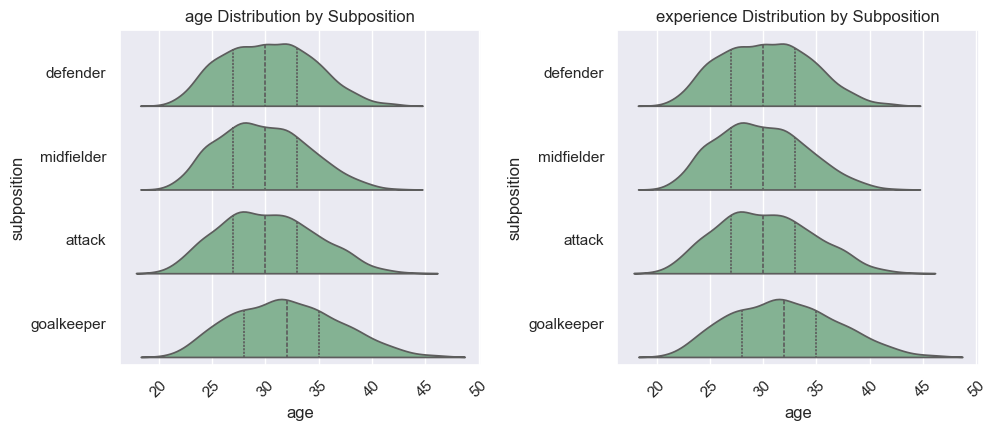

In [11]:
# # Calculate age based on the birthday_date and experience based on club_joined
def age(df):
    df['age'] = df['birthday_date'].apply(pd.to_datetime).apply(lambda x: 2024 - x.year)
    return df

#experience
def experience(df):
    df['experience'] = df['club_joined'].apply(pd.to_datetime).apply(lambda x: 2024 - x.year)
    return df

df = age(df)
df = experience(df)

plt.figure(figsize=(20, 8))
for i, feature in enumerate(['age', 'experience'], 1):
    plt.subplot(2, 4, i)
    sns.violinplot(data=df, y="subposition", x="age",split=True, inner="quart", fill=True)
    plt.title(f'{feature} Distribution by Subposition')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


There are no significant differences in the distribution parameters of Age and Experience by subposition. We can only observe that the distributions for goalkeepers appear to be flatter, possibly due to the presence of older players in this subposition. However, in general, these features do not seem to capture any significant patterns that could predict the position

In [12]:
df.nlargest(15, 'wage_eur')[['short_name', 'experience', 'subposition']]

short_name  experience subposition
789        K. De Bruyne         9.0  midfielder
625            L. Messi         3.0      attack
539            T. Kroos        10.0  midfielder
2871           Casemiro        11.0  midfielder
1685           M. Salah         7.0      attack
1850            S. Mané         8.0      attack
1870     R. Lewandowski        10.0      attack
2224  Cristiano Ronaldo         3.0      attack
5335          Neymar Jr         7.0      attack
3361          R. Lukaku         3.0      attack
6874          S. Agüero         3.0      attack
2452      M. ter Stegen        10.0  goalkeeper
2895        T. Courtois         6.0  goalkeeper
4576    Bruno Fernandes         4.0  midfielder
1956          E. Hazard         5.0      attack

The `club_joined` column may not be the best variable to represent experience, as it only reflects the player's most recent contract with the club. A player may have played for other clubs previously, and we lose the experience accumulated from those years.

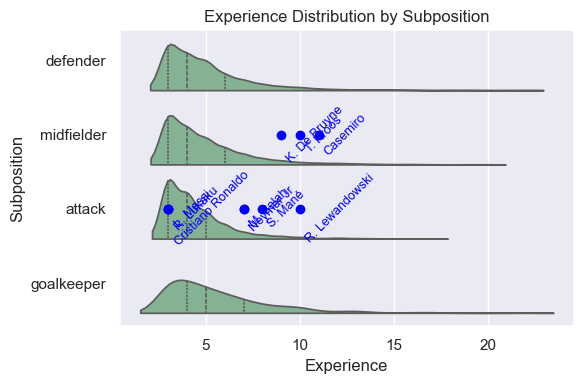

In [13]:
df['experience'] = df['club_joined'].apply(pd.to_datetime).apply(lambda x: 2024 - x.year)
top_players = df.nlargest(10, 'wage_eur')
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, y="subposition", x="experience", split=True, inner="quart", fill=True)
plt.scatter(top_players['experience'], top_players['subposition'], color='blue', zorder=3)
for i, row in top_players.iterrows():
    plt.text(row['experience'] + 0.2, row['subposition'], row['short_name'], color='blue', ha='left', va='center', fontsize=9,rotation=45)
plt.title("Experience Distribution by Subposition")
plt.xlabel("Experience")
plt.ylabel("Subposition")

plt.tight_layout()
plt.show()

In [14]:
nationality_counts = df['nationality_name'].value_counts()
threshold = 10
df['nationality_name_grouped'] = df['nationality_name'].apply(
    lambda x: x if nationality_counts[x] >= threshold else 'Other'
)
def create_treemap(df, column1, column2):
    custom_palette = ['#2D3773', '#275D8C', '#3498db', '#1F6D8C', '#5DA68B', '#5DA68B', '#9BBF8A', '#398A8D', '#2C3372']
    fig = px.treemap(df, 
                    path=[column1,column2, 'position'],  
                    title=f"{column1} Distribution by {column2}",
                    color=column2,
                    color_discrete_sequence=custom_palette,
                    hover_data=[column1,column2],
                    labels={column2: column2, f'{column1}': f'{column1}'})
    fig.update_traces(textinfo="label+value+percent entry")
    fig.show()
create_treemap(df, 'subposition', 'nationality_name_grouped')

In [15]:
create_treemap(df, 'side',  'nationality_name_grouped')

From the 2 previous plots, we cannot observe a clear pattern that would suggest certain countries are known for developing players for specific positions or have strengths in particular areas of the field. However, since the distributions are not identical, we will retain this feature for the model. It’s possible that some non-linear relationships could still be useful for predicting the outcome.

In [16]:
def create_continent(df):
    with open('country_continent.json', 'r') as file:
        country_continent_map = json.load(file)
    df['continent'] = df['nationality_name'].map(country_continent_map)
    return df
df = create_continent(df)

In [17]:
create_treemap(df, 'subposition',  'continent')

Grouping countries by continent doesn't seem to help in identifying any further patterns. In this case, maybe retaining this feature does not worth it.

### 2. **Physical, Power and Endurance Attributes**
Physical attributes such as **height** and **weight** are crucial for certain positions. For example, goalkeepers tend to be taller, while attackers may have a more agile build.

#### Features:
- `height_cm`, `weight_kg`, `physic`, `power_shot_power`, `power_jumping`, `power_stamina`:

#### Analysis:
- **Height and weight distribution by `subposition`**: Different positions require different physical characteristics.
- **Relationship between `physic` and `subposition`**: The physical attribute reflects stamina, strength, and agility, which are key for defending or attacking.




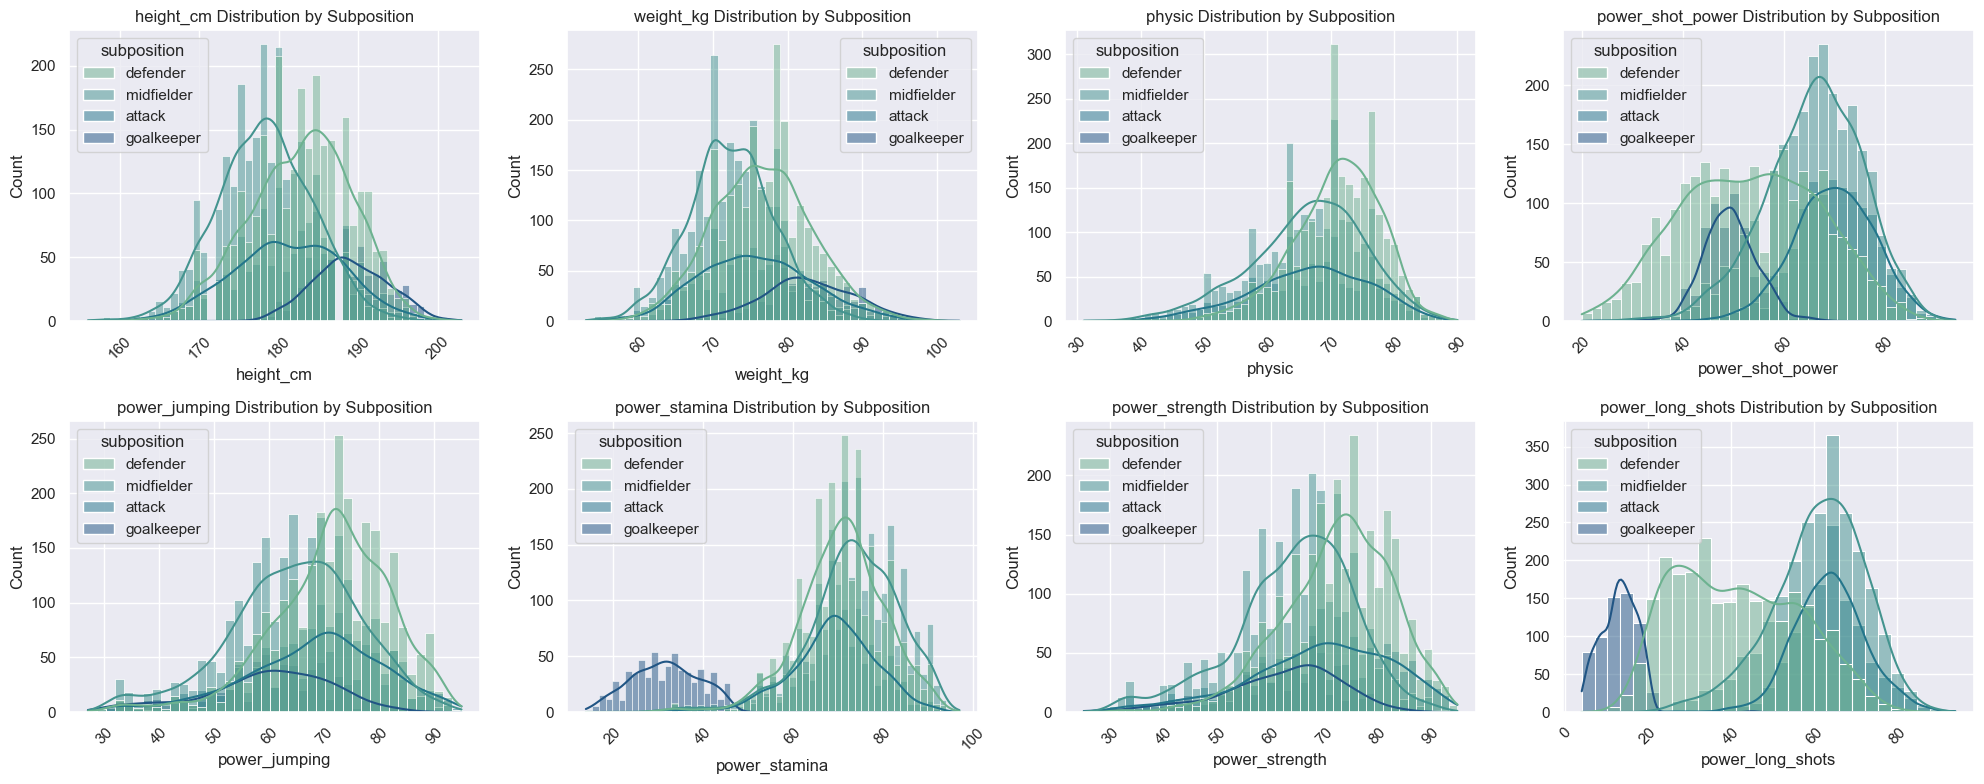

In [18]:
violin_features = ['height_cm', 'weight_kg', 'physic', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength','power_long_shots']
plt.figure(figsize=(20, 8))
for i, feature in enumerate(violin_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(hue='subposition', x=feature, data=df, kde=True, palette="crest", common_norm=True)
    plt.title(f'{feature} Distribution by Subposition')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


- The most clear pattern from this plot is that goalkeepers have a different and right-skewed distribution for power stamina and long shot attributes, which makes sense because goalkeepers are typically less involved in high-intensity running and long-range shooting compared to outfield players. Their training focuses more on reflexes, positioning, and shot-stopping, which could explain their lower values in these attributes.

- For the other attributes, it is difficult to see any clear differences between defenders, attackers, and midfielders:

    - The last two positions (attackers and midfielders) seem to have a more left-skewed distribution for power shot, and defenders, in particular, show a left-skew in power strength and power jumping. This is intuitive because defenders often rely on physical strength and jumping ability to win aerial duels and protect the goal, whereas attackers and midfielders may focus more on speed and agility.

    - In terms of weight and height, we observe that attackers may have a slightly right-skewed distribution, differentiating them from the others. This makes sense as attackers often tend to be lighter and more agile to enhance their speed and maneuverability, while defenders and midfielders may have more balanced or higher body mass to deal with physical duels

`body_type` could be a variable that summarizes some of the phisycal/natural attributes of the player and could reduce the dimension of the model. Let's see if we can identify any pattern by subposition.

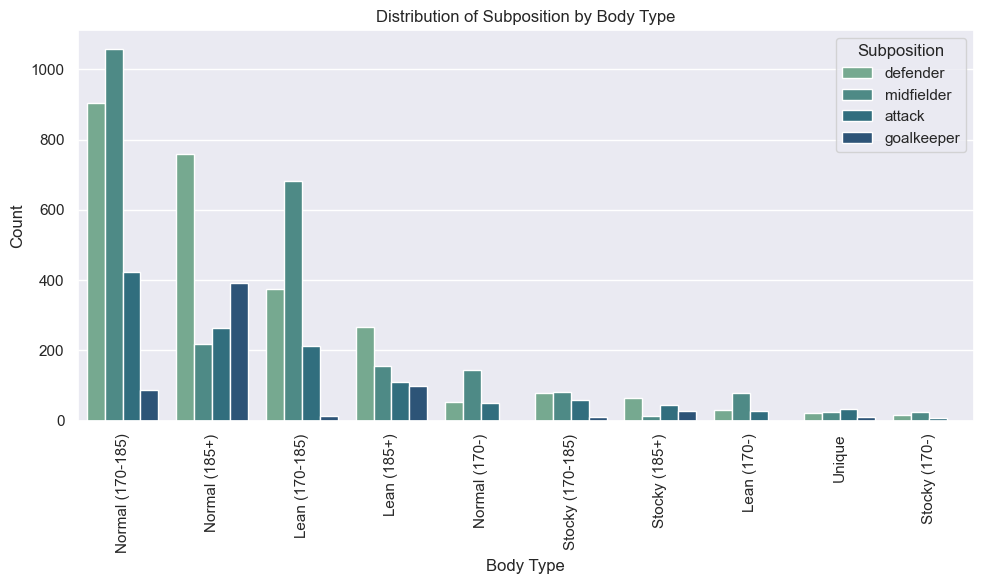

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 6))

body_type_order = df['body_type'].value_counts().index
unique_subpositions = df['subposition'].unique()


sns.countplot(data=df, x='body_type', hue='subposition', palette='crest', ax=ax1, order=body_type_order)
ax1.set_title("Distribution of Subposition by Body Type")
ax1.set_xlabel("Body Type")
ax1.set_ylabel("Count")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.legend(title='Subposition')

plt.tight_layout()
plt.show()


We can see that the big part of the players are concentrated in the first 4 categories, where the midfiedlers and defenders are predominantly normal between $170$ and $+185$, while goalkeepers (and also defenders) are in the cateogry normal $+185$, as we expect more height and also strong bodies.


### 3. **Gameplay Attributes (Technical and Mental Skills)**
This section analyzes skills in football, such as **attacking**, **defending**, **passing**, and **mental skills** such as **composure** and **aggression**, which are crucial for different roles on the field.

----

#### **Features representing different aspects of a player's playing style and skills**

#### Analysis:

When analyzing the **distribution of skills across `subposition`**, we would expect distinct patterns reflecting the specific demands of each role. 
- Atacckers typically excel in pace, shooting, and dribbling, as these are crucial for creating and capitalizing on scoring opportunities. 

    - `pace`: Crucial for outrunning defenders.
    - `shooting`: Key for scoring goals.
    - `dribbling`: Useful for getting past opponents in tight spaces.

- Defenders, on the other hand, should show higher values in defending and physic, as these attributes are essential for stopping opponents and winning physical duels, with some reliance on pace to keep up with fast attackers. - 

    - `defending`: Essential for stopping opposing attacks.
    - `physic`: Important for aerial duels and physical battles.
    - `pace`: Helps keep up with fast attackers.

- Midfielders are expected to have a more balanced profile, excelling in passing and dribbling to facilitate play between defense and attack, while also maintaining solid physic to endure the high physical demands of their role. 

    - `passing`: Vital for distributing the ball effectively.
    - `dribbling`: Helps transition the ball between lines.
    - `physic`: Necessary for physical endurance and winning contested balls.




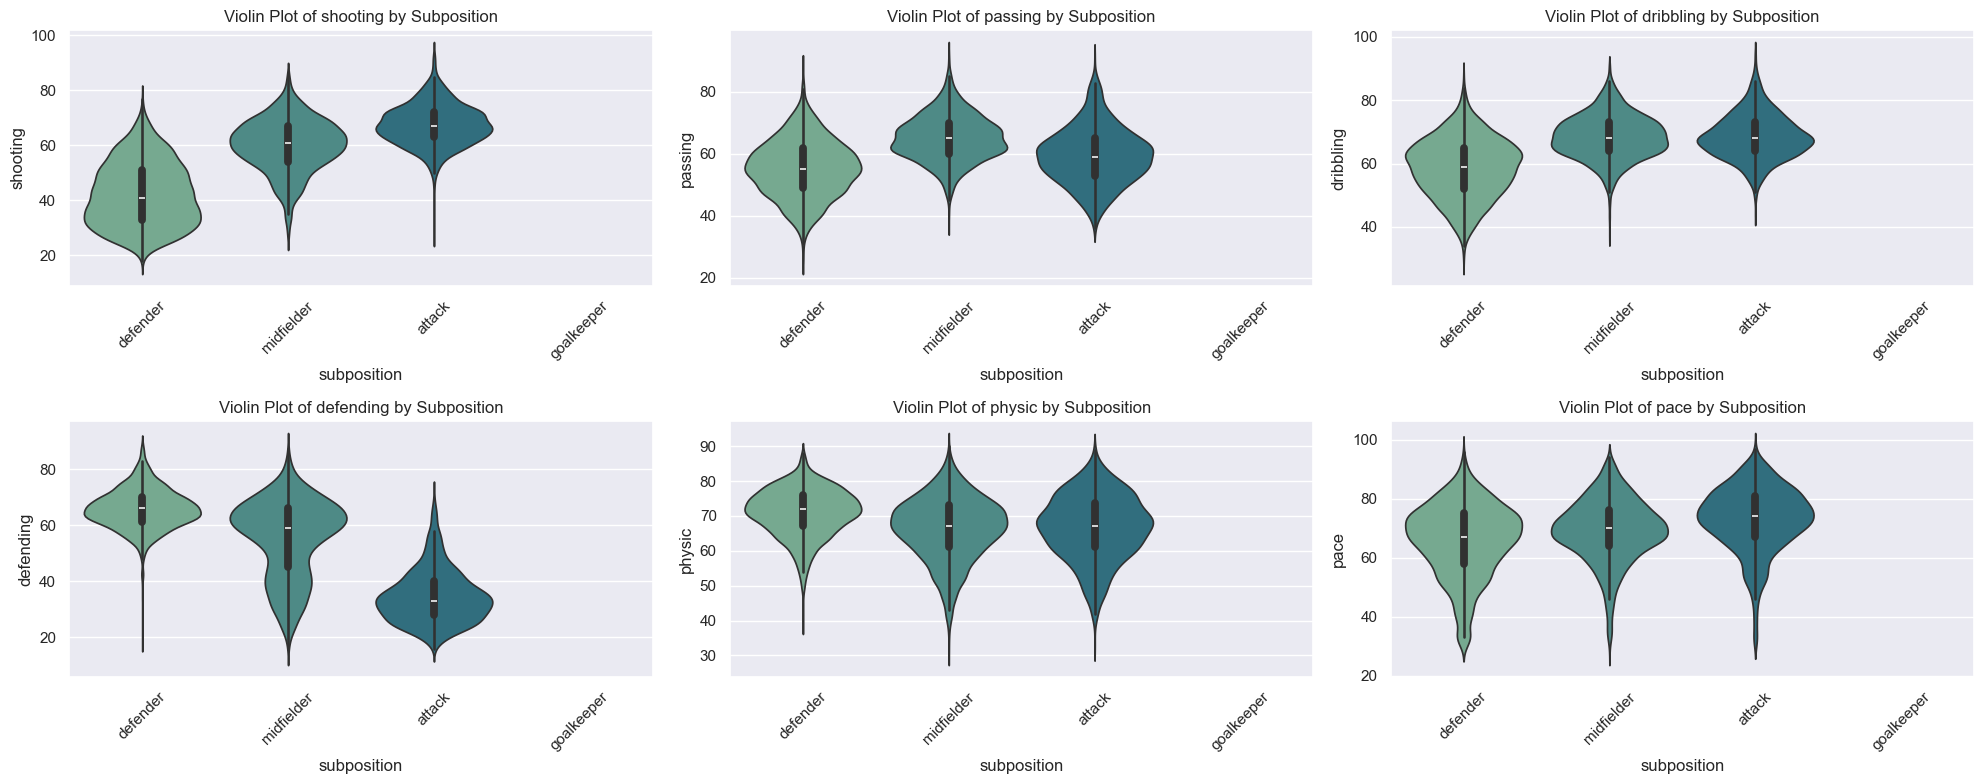

In [20]:
violin_features = ['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace']
plt.figure(figsize=(20, 8))
for i, feature in enumerate(violin_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='subposition', y=feature, data=df, palette='crest')
    plt.title(f'Violin Plot of {feature} by Subposition')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Attackers and midfielders clearly have left skew distribution in shooting and dribbling skills, while defenders and midfielders have a left skew distirbution for defending skills, with defenders having the most pronounced skew. Regarding the other attributes, there seems to be little correlation with player subposition, implying that these attributes are more universal and present across all player types, rather than being specific to one position group.

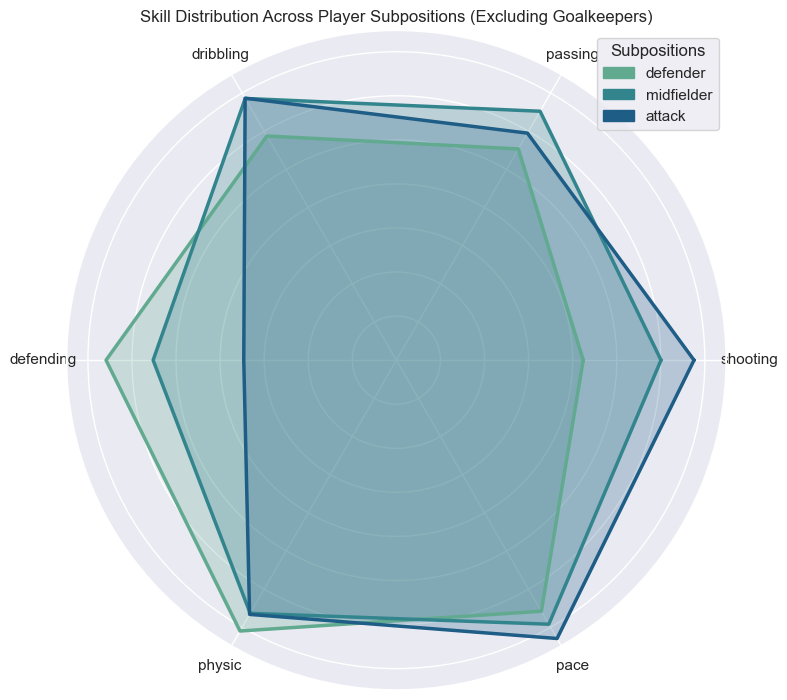

In [21]:
radar_features = ['shooting', 'passing', 'dribbling', 'defending', 'physic', 'pace']
df_normalized = df[radar_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_filtered = df[df['subposition'] != 'goalkeeper']
def radar_plot(ax, data, labels, color, label, title=None):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    data = data.tolist()
    data += data[:1]
    angles += angles[:1]
    ax.fill(angles, data, color=color, alpha=0.25)
    ax.plot(angles, data, color=color, linewidth=2.5)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    if title:
        ax.set_title(title, size=16)    
    return label
fig, ax = plt.subplots(figsize=(8, 8), dpi=100, subplot_kw=dict(polar=True))
palette = sns.color_palette("crest", n_colors=df_filtered['subposition'].nunique(), as_cmap=False)
for i, subposition in enumerate(df_filtered['subposition'].unique()):
    subposition_data = df_filtered[df_filtered['subposition'] == subposition][radar_features].mean()
    color = palette[i]
    radar_plot(ax, subposition_data, radar_features, color, subposition)
legend_labels = [Patch(color=palette[i], label=subposition) for i, subposition in enumerate(df_filtered['subposition'].unique())]
ax.legend(handles=legend_labels, title="Subpositions", loc='upper right')
plt.title('Skill Distribution Across Player Subpositions (Excluding Goalkeepers)')
plt.tight_layout()
plt.show()


From this plot we could carachterize the main skills by these subpositions:

- Attackers tend to stand out in shooting and pace, but show lower scores in physical attributes compared to the other subpositions.
- Defenders excel in defending and physical attributes, distinguishing them from the other subpositions.
- Midfielders score the highest in passing, but do not have any specific attributes that clearly differentiate them from the others. They appear to be the most balanced category across all attributes.

#### **Features representing different aspects of a player's mental skills**

**Attributes representing mental aspects of a player's game**

- `mentality_aggression`, `mentality_interceptions`,`mentality_positioning`, `mentality_vision`, `mentality_penalties`,`mentality_composure`

#### Analysis:

When analyzing the **distribution of mental skills across `subposition`**, we would expect distinct patterns reflecting the specific demands of each role. 


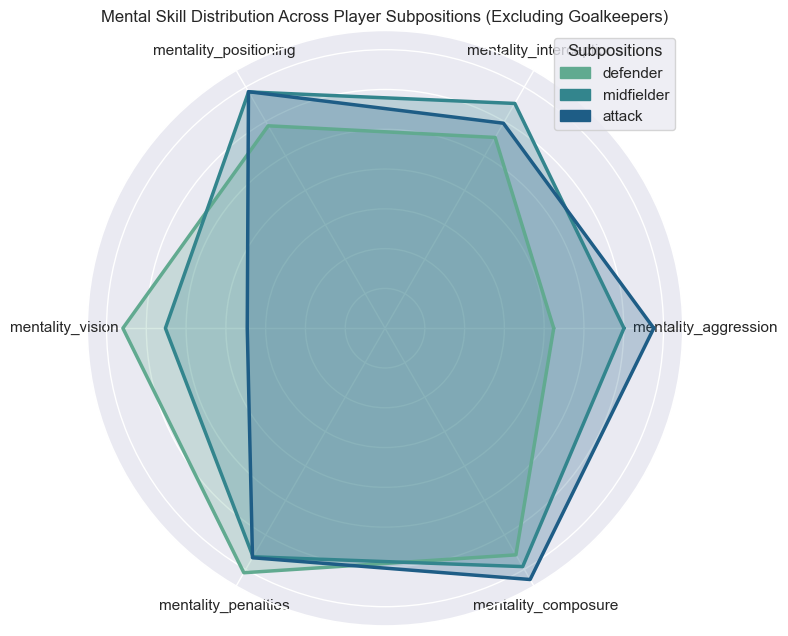

In [22]:
mentality_features = ['mentality_aggression', 'mentality_interceptions', 
                      'mentality_positioning', 'mentality_vision', 
                      'mentality_penalties', 'mentality_composure']
df_normalized = df[mentality_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_filtered = df[df['subposition'] != 'goalkeeper']
fig, ax = plt.subplots(figsize=(8, 8), dpi=100, subplot_kw=dict(polar=True))
palette = sns.color_palette("crest", n_colors=df_filtered['subposition'].nunique(), as_cmap=False)
for i, subposition in enumerate(df_filtered['subposition'].unique()):
    subposition_data = df_filtered[df_filtered['subposition'] == subposition][radar_features].mean()
    color = palette[i]
    radar_plot(ax, subposition_data, mentality_features, color, subposition)
legend_labels = [Patch(color=palette[i], label=subposition) for i, subposition in enumerate(df_filtered['subposition'].unique())]
ax.legend(handles=legend_labels, title="Subpositions", loc='upper right')
plt.title('Mental Skill Distribution Across Player Subpositions (Excluding Goalkeepers)')
plt.tight_layout()
plt.show()

Overall, we can say that attackers have a strong mentality agression, defenders differenciate by having a strong mentality vision and midfielders in mentality interceptions.

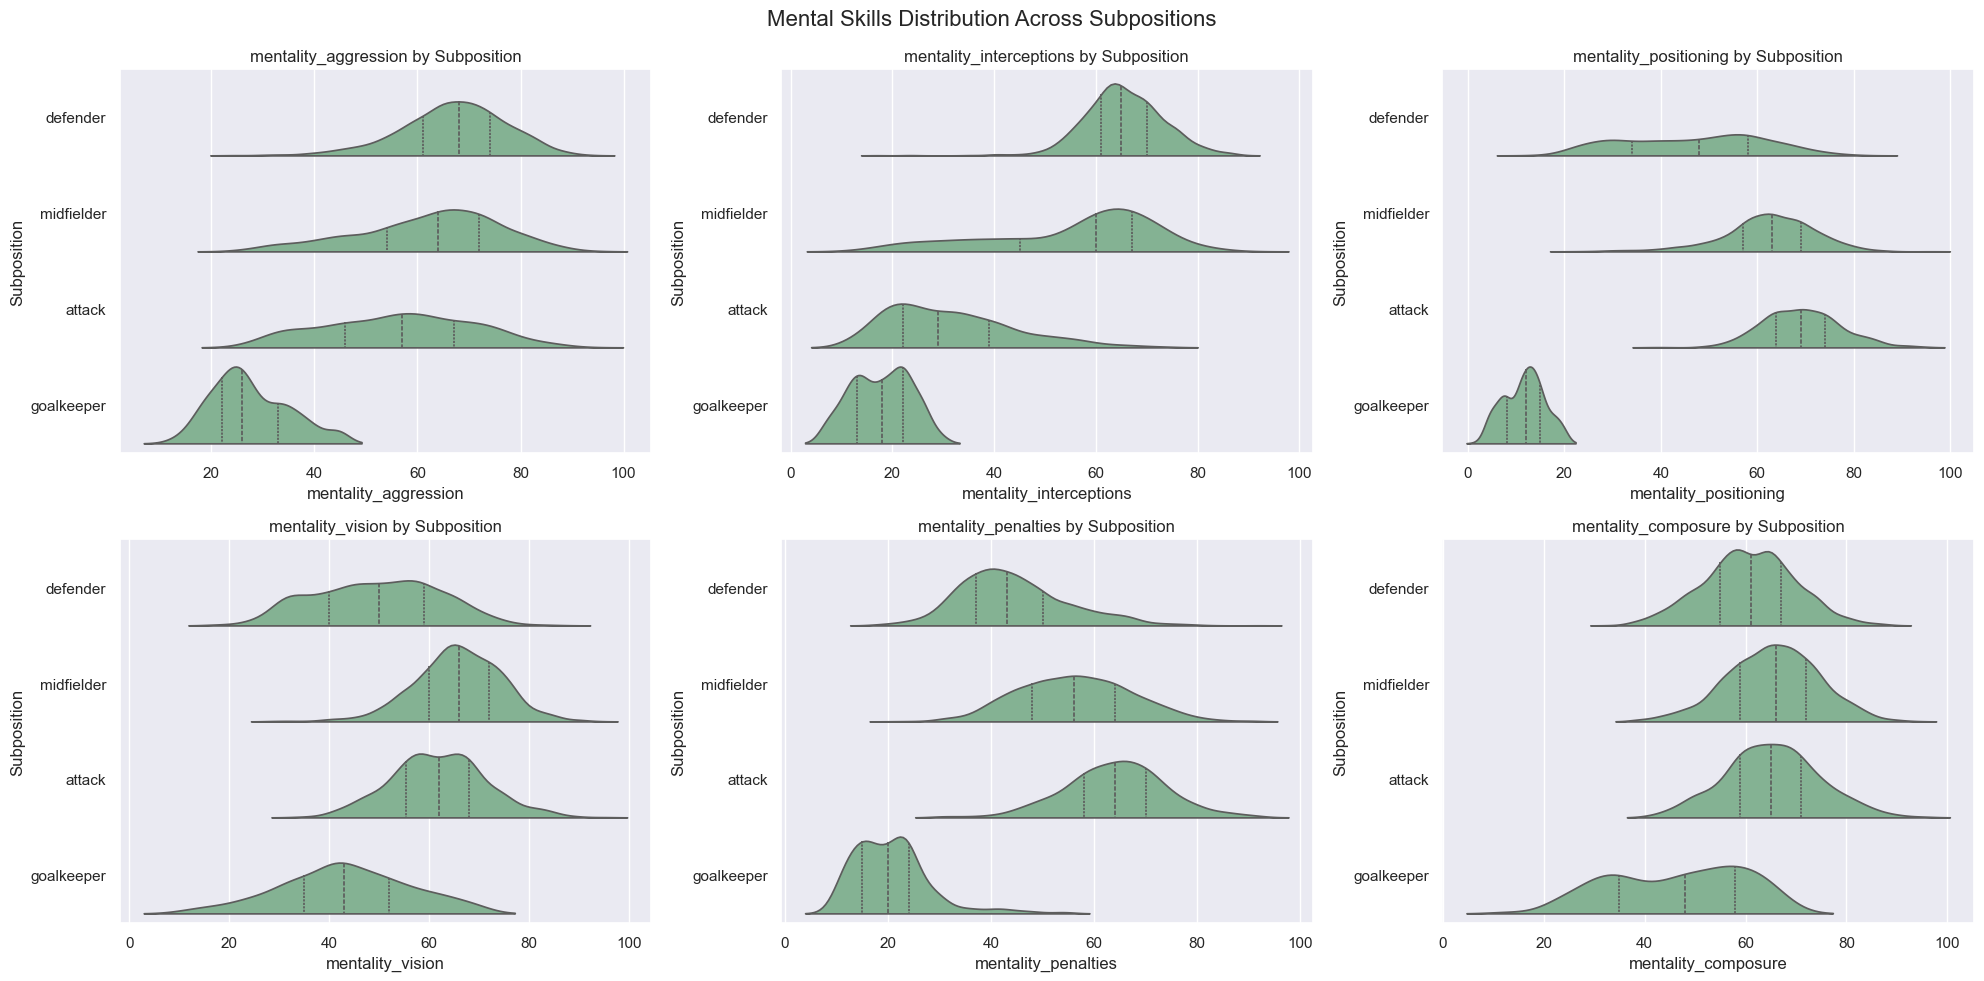

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
for i, feature in enumerate(mentality_features):
    sns.violinplot(data=df, y="subposition", x=feature,split=True, inner="quart", fill=True, ax=axes[i])
    axes[i].set_title(f"{feature} by Subposition")
    axes[i].set_ylabel("Subposition")
    axes[i].set_xlabel(feature)
fig.suptitle('Mental Skills Distribution Across Subpositions', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92) 
plt.show()

From this plot it is clear that goalkeeper is the category with the most different behavior in all the mentality skills, but we also can appreciate some differences in distributions by subpositions across these features, which indicate that they may help in the predictions.

#### **Features analysis for `side`**

The following features are considered most important when predicting which side of the field a player plays on (left, right, or central):

1. **`preferred_foot`**: This is a key indicator as players typically play on the side that suits their dominant foot. 

2. **`attacking_crossing`**: Players who are positioned on the wings (left or right) are often expected to deliver crosses into the box. Thus, crossing ability is highly relevant for predicting a player's side.

3. **`movement_sprint_speed`** and **`movement_agility`**: These attributes are often more important for players on the wings who need to rely on speed and agility to beat defenders. Players in central positions typically require different skill sets focused more on positioning and control.

4. **`dribbling`**: Dribbling ability is especially relevant for players on the flanks, where quick turns and beating defenders are essential. Central players may not need this skill as much.

5. **`work_rate`**: A higher work rate is typically associated with central players who are expected to cover more ground defensively and offensively, while wingers may have a more specialized attacking focus.


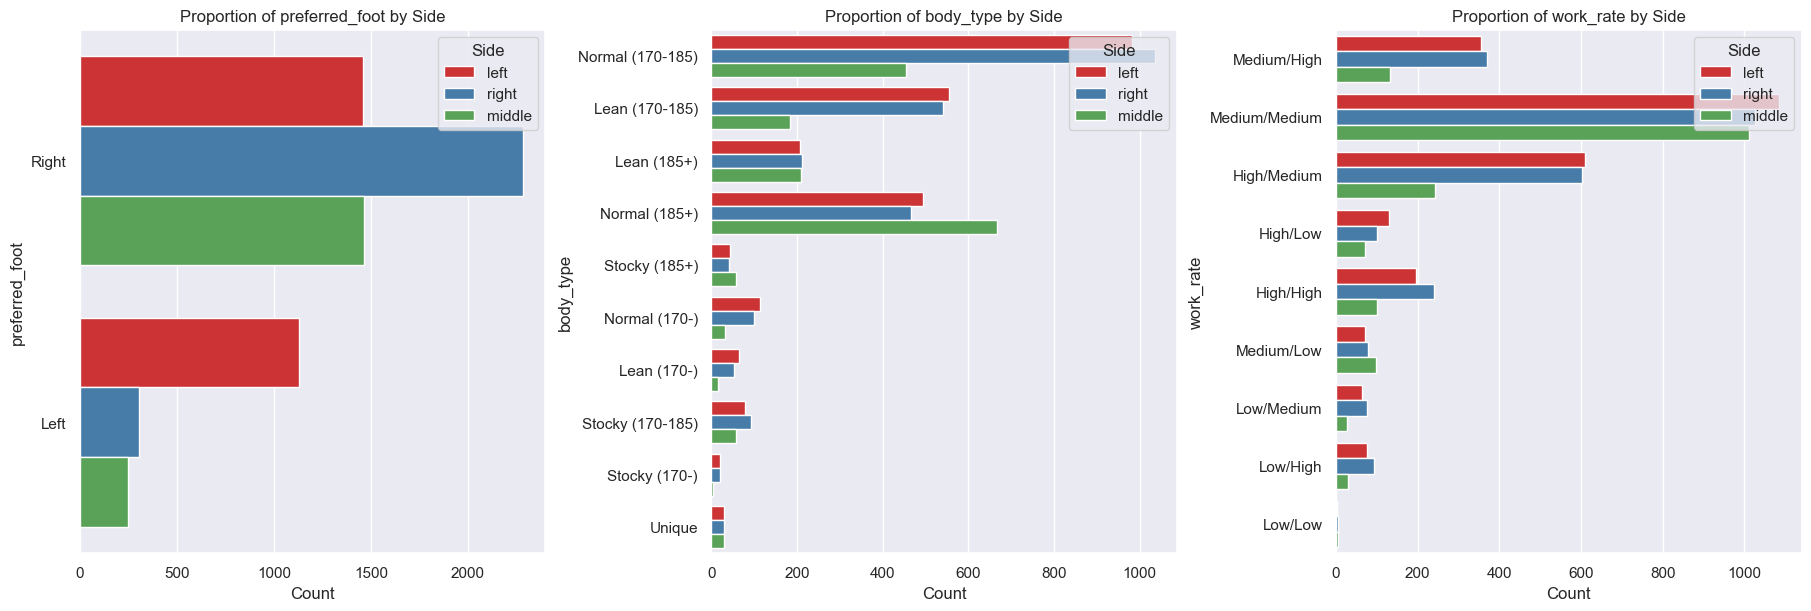

In [24]:
categorical_features = ['preferred_foot', 'body_type', 'work_rate']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
for ax, feature in zip(axes, categorical_features):
    sns.countplot(y=feature, hue='side', data=df, palette='Set1', ax=ax)
    ax.set_title(f'Proportion of {feature} by Side')
    ax.set_xlabel('Count')
    ax.set_ylabel(feature)
    ax.legend(title='Side', loc='upper right')
plt.show()

- From the plot on the left, we can observe consistency in the data: players with right positions tend to prefer their right foot, and vice versa.

- In the plot in the middle, most of the data is concentrated in the four categories of body type. It appears that the middle category, which consists primarily of goalkeepers, is concentrated in the 'normal' body type with tall height. However, for the other body type categories, no clear distinction by side (left or right) in the position played on the field can be observed.

- Regarding work rate, a large proportion of players have a medium-medium work rate. For the other work rates, there are no significant differences between left- and right-sided players. The only exception is the 'middle' category, which shows a distinct behavior, indicating that it is likely to be the easiest category to predict.

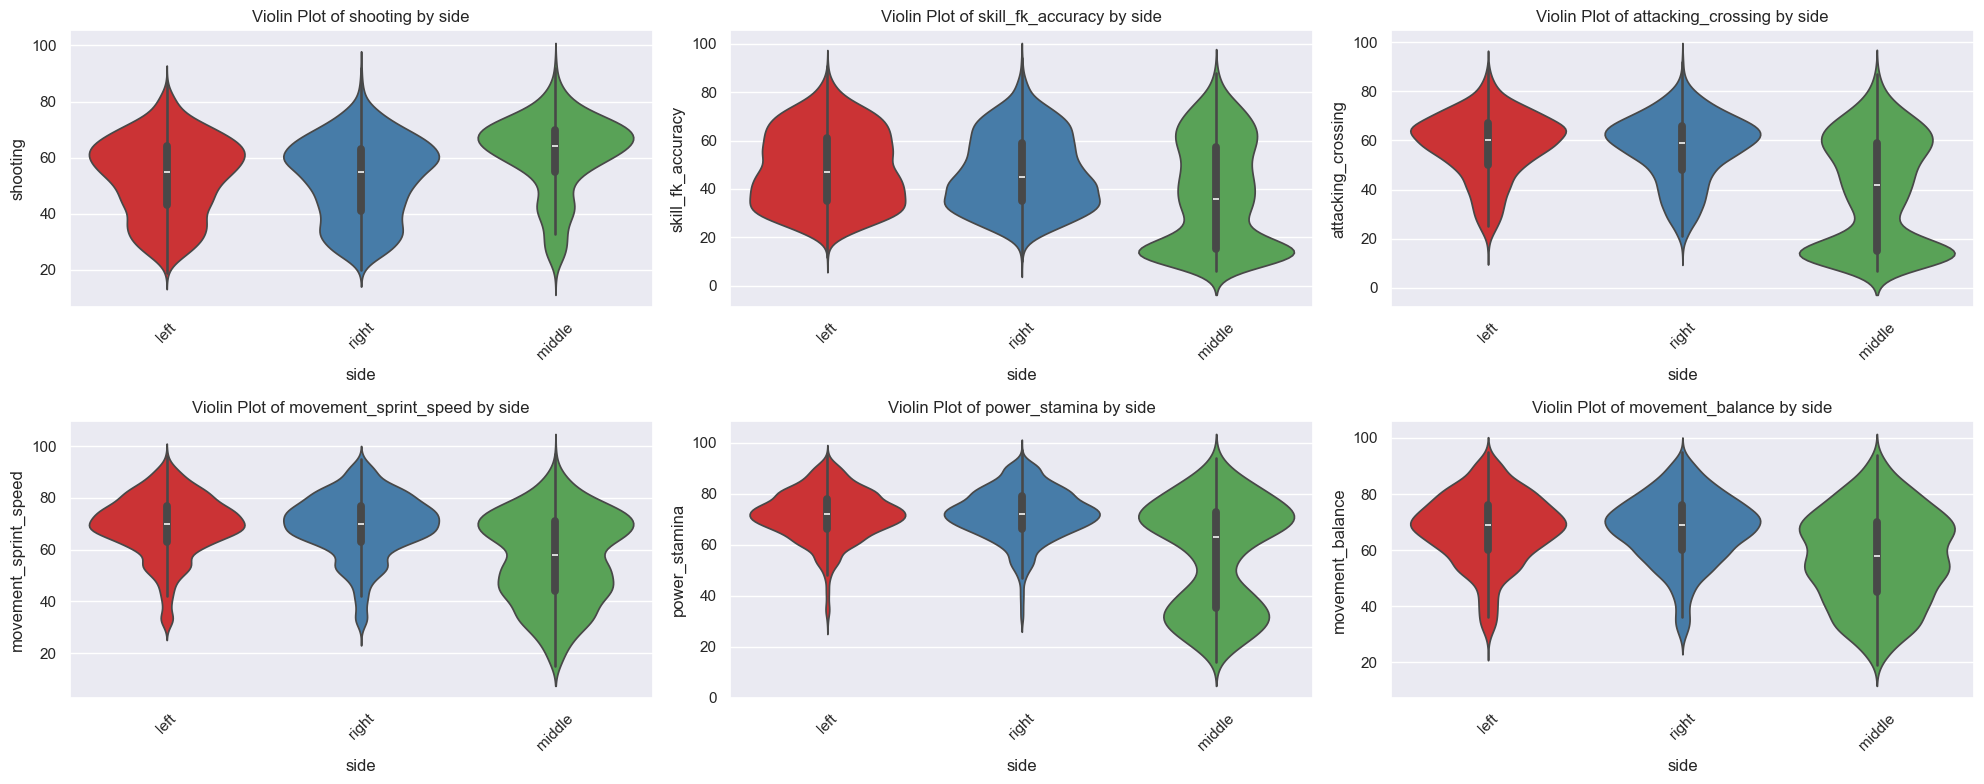

In [25]:
violin_features = ['shooting', 'skill_fk_accuracy', 'attacking_crossing', 'movement_sprint_speed', 'power_stamina', 'movement_balance']
plt.figure(figsize=(20, 8))
for i, feature in enumerate(violin_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='side', y=feature, data=df, palette='Set1')
    plt.title(f'Violin Plot of {feature} by side')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. **Movement and Agility Attributes**
**Agility**, **speed**, and **acceleration** are crucial for some positions. Attackers and midfielders typically need greater speed, while defenders may need more strength or endurance.

#### Features:
- `movement_acceleration`, `movement_sprint_speed`, `movement_agility`, `movement_balance`, `movement_reactions`

---


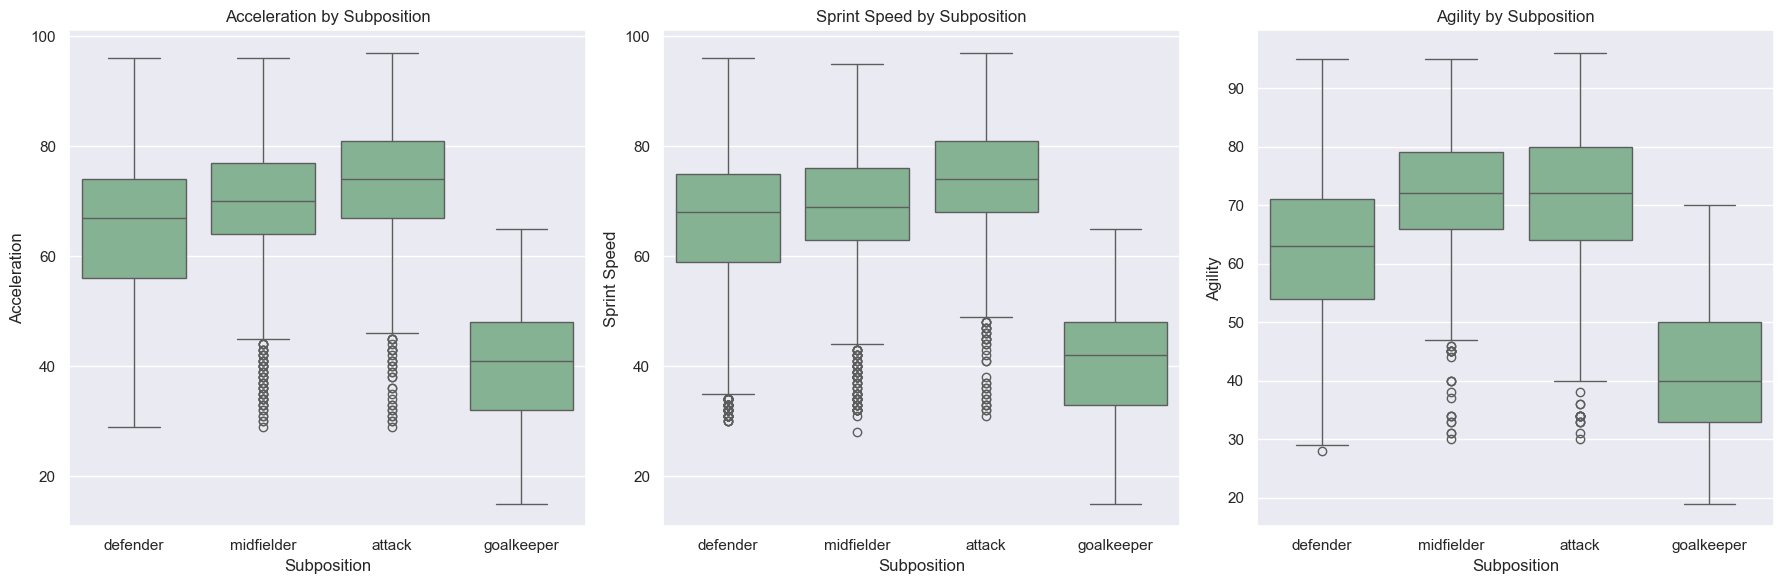

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='subposition', y='movement_acceleration', data=df, ax=axes[0])
axes[0].set_title("Acceleration by Subposition")
axes[0].set_xlabel("Subposition")
axes[0].set_ylabel("Acceleration")

sns.boxplot(x='subposition', y='movement_sprint_speed', data=df, ax=axes[1])
axes[1].set_title("Sprint Speed by Subposition")
axes[1].set_xlabel("Subposition")
axes[1].set_ylabel("Sprint Speed")

sns.boxplot(x='subposition', y='movement_agility', data=df, ax=axes[2])
axes[2].set_title("Agility by Subposition")
axes[2].set_xlabel("Subposition")
axes[2].set_ylabel("Agility")

plt.tight_layout()
plt.show()


### 5. **Market Value and Reputation**
**Market value** and **international reputation** are indicators of a player's perceived quality. Higher-value players are usually the best in their positions.

#### Features:
- `value_eur`, `wage_eur`, `international_reputation`, `release_clause_eur`

---


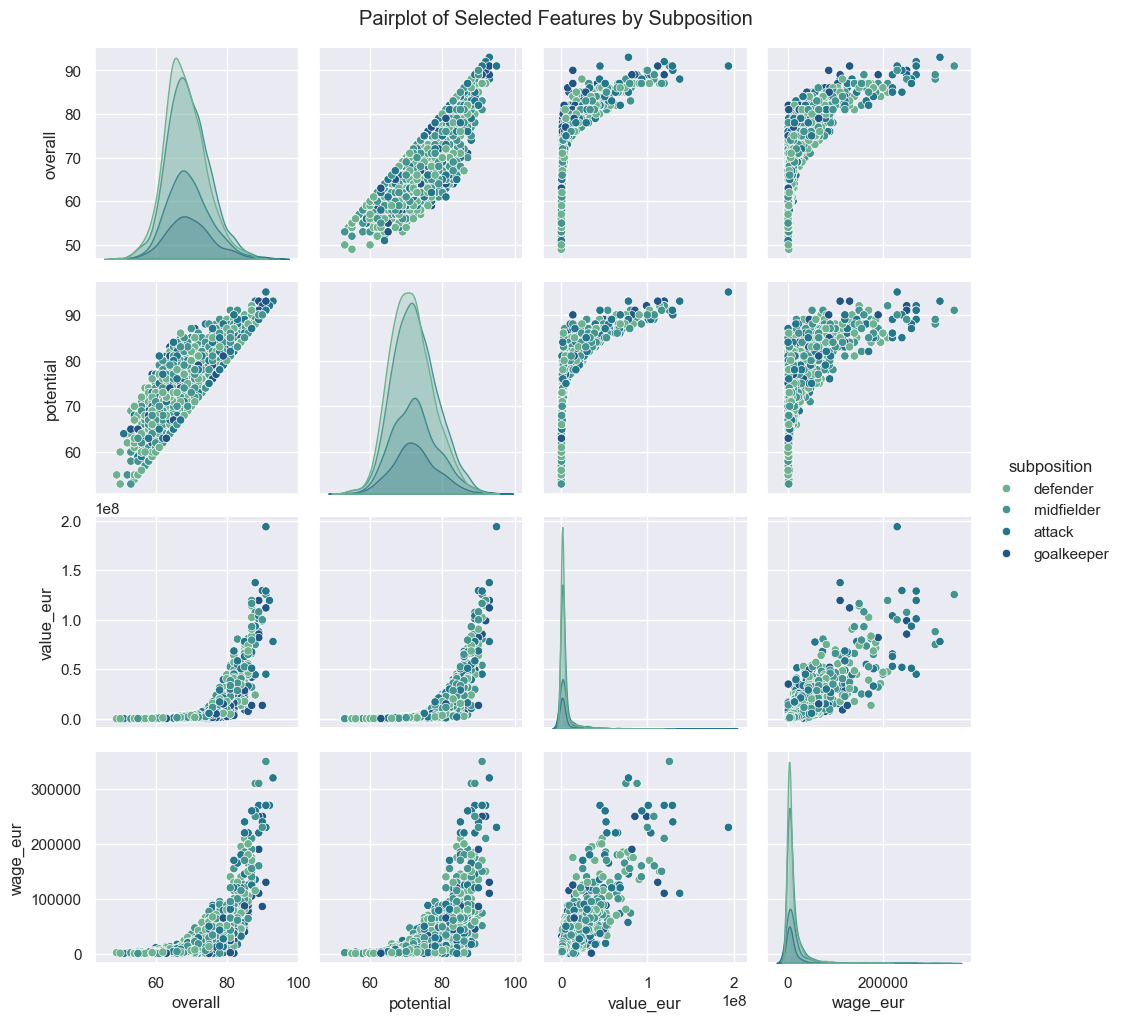

In [27]:
pairplot_features = ['overall', 'potential', 'value_eur', 'wage_eur']
sns.pairplot(df[pairplot_features + ['subposition']], hue='subposition', palette='crest')
plt.suptitle('Pairplot of Selected Features by Subposition', y=1.02)
plt.show()

- From the previous plot, in general we can not observe a distinctive pattern by subposition in the variables analyzed.
- It can be observed the right skew of the wage and value variables, wich tipically tend to have high outliers, but we can not observe difference by subpositions.
- It seem that overall has a positive correlation with wage, and potential having a convex relation, while value with value with wage and potential with wage and value have a positive correlation but more concave.


### 6. **Goalkeeper Attributes**
There are some columns that differentiate the specific skills for goalkeepers, such as **diving**, **handling**, and **reflexes**, which do not apply to outfield players.

#### Features:
- `goalkeeping_diving`, `goalkeeping_handling`, `goalkeeping_kicking`, `goalkeeping_positioning`, `goalkeeping_reflexes`

#### Analysis:
- **Distribution of goalkeeper skills by `subposition`**: These skills are exclusive to goalkeepers.

----


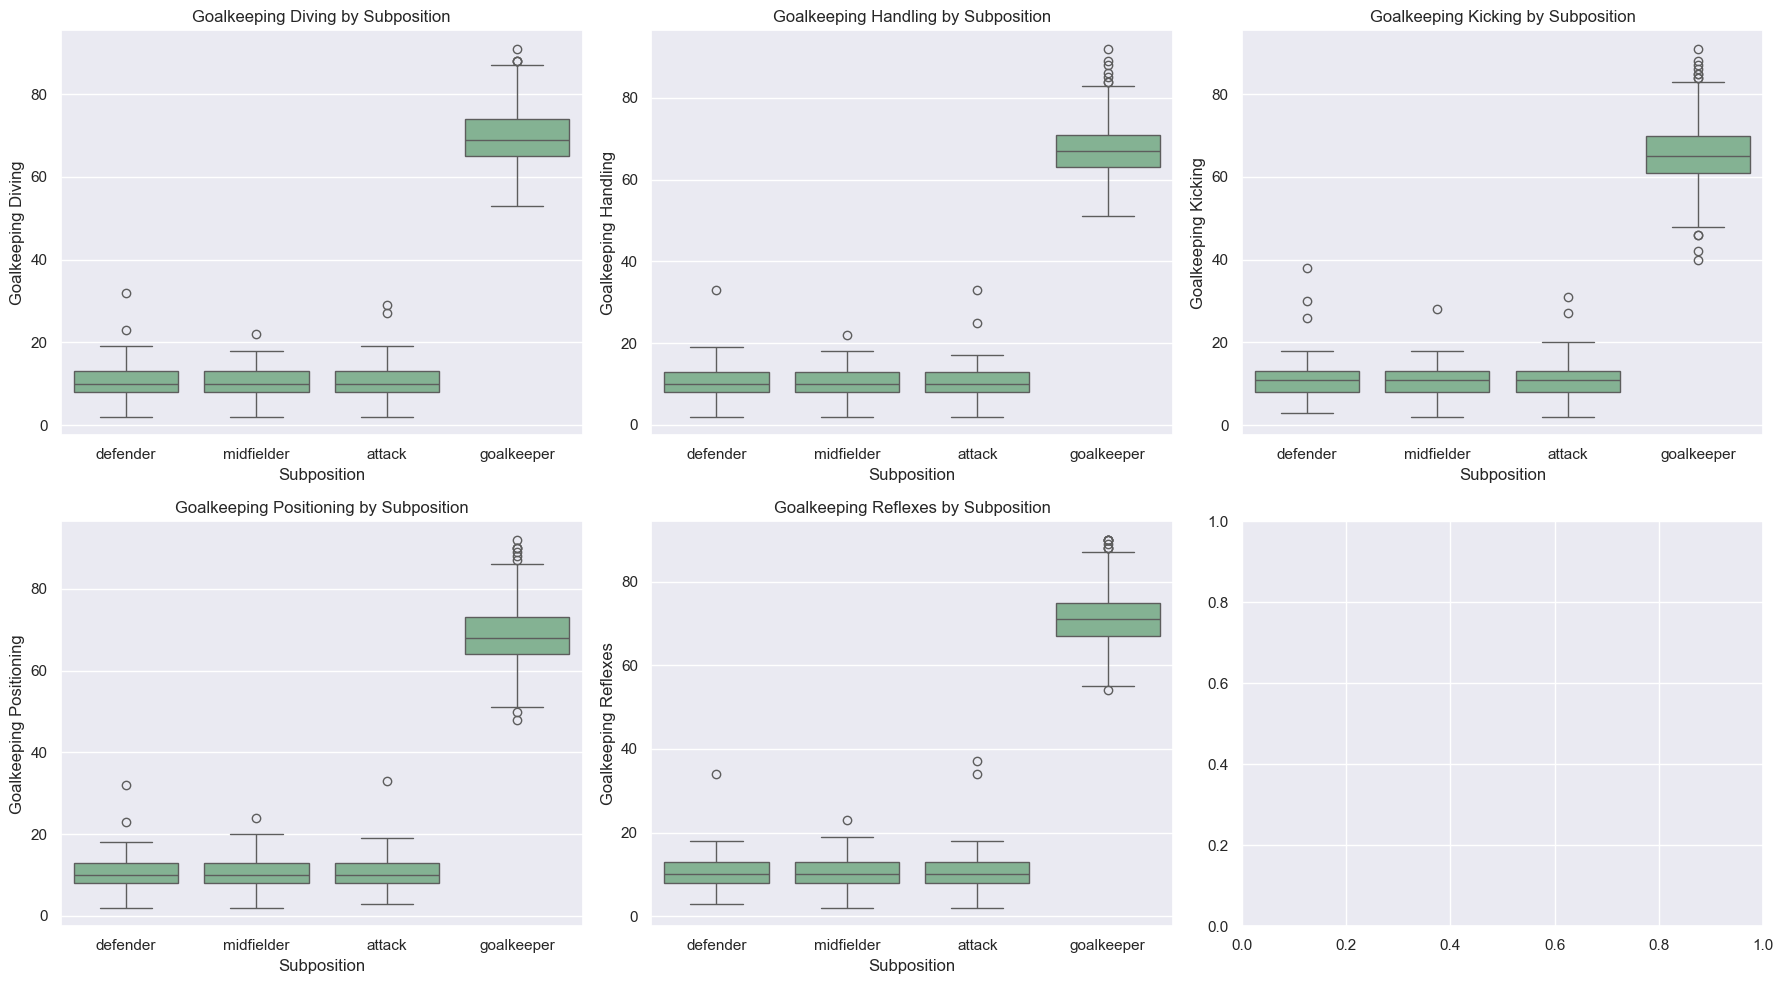

In [28]:
goalkeeper_columns = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for idx, col in enumerate(goalkeeper_columns):
    sns.boxplot(x='subposition', y=col, data=df, ax=axes[idx//3, idx%3])
    axes[idx//3, idx%3].set_title(f"{col.replace('_', ' ').title()} by Subposition")
    axes[idx//3, idx%3].set_xlabel("Subposition")
    axes[idx//3, idx%3].set_ylabel(col.replace('_', ' ').title())
plt.tight_layout()
plt.show()

In these section it clear that the goalkeepers are going to be likely the easiest category to be predicted.

#### Check for Multicolinearity

- The following matrix will help us identify if there is perfect correlation between any of the features. 

- Additionally, if we find groups of features that are highly correlated and similar in meaning, we could reduce the number of features by creating a single feature, possibly as an average of those correlated ones.

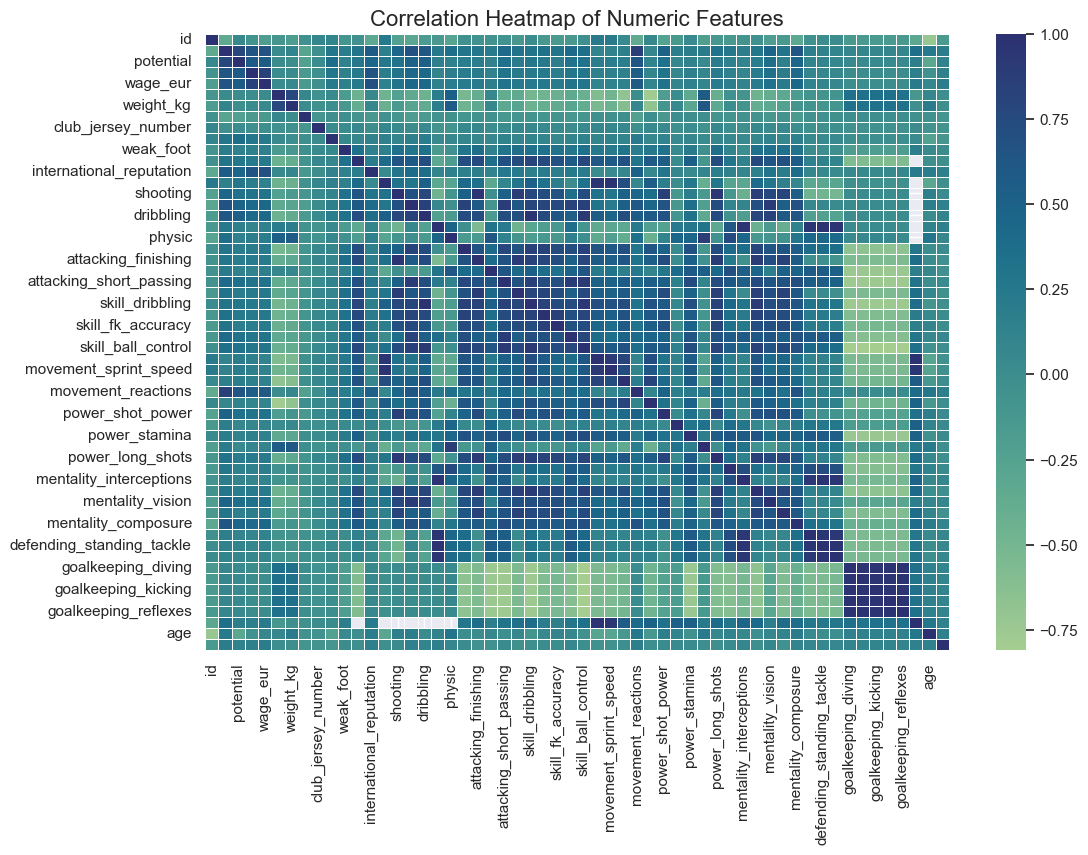

In [29]:
numeric_features = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='crest', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

In [30]:
def skills_average(df):
    df['goalkeeping_average'] = df[['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']].mean(axis=1)
    df['defense_average'] = df[['defending_marking_awareness','defending_standing_tackle', 'defending_sliding_tackle', 'defending_marking_awareness', 'defending']].mean(axis=1)
    df['attacking_average'] = df[['attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing']].mean(axis=1)
    df['mentality_average'] = df[['mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure']].mean(axis=1)
    df['power_average'] = df[['power_shot_power','power_jumping', 'power_stamina', 'power_strength', 'power_long_shots']].mean(axis=1)
    df['movement_average'] = df[['movement_acceleration', 'movement_sprint_speed', 'movement_agility','movement_reactions', 'movement_balance']].mean(axis=1)
    df['skills_average'] = df[['skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'skill_moves']].mean(axis=1)

    return df

#### **Feature Selection**
---

Before running the model we could run a **Random Forest** to determine which features explain the most variability in the target variable excluding the goalkeepers class that showed to be the easiest one to preditc.

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_5644/1728312582.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_5644/1728312582.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_5644/1728312582.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

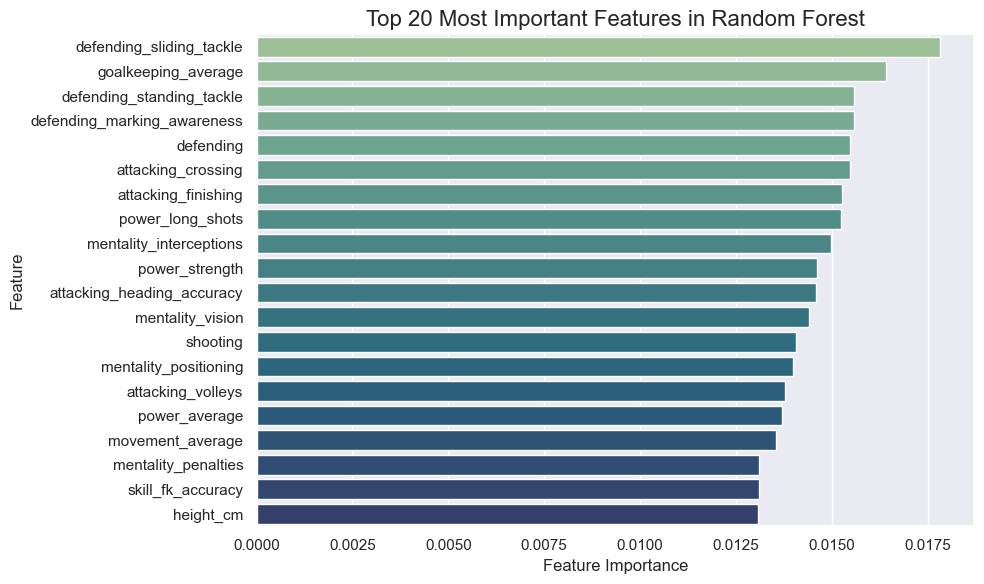

In [31]:
df_filtered = skills_average(df_filtered)
X = df_filtered.drop(columns=['subposition', 'side', 'position', 'id', 'club_contract_valid_until', 'short_name'], axis=1)
y = df_filtered['position']
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns
preprocessor = ColumnTransformer(transformers=[('num', Pipeline([('imputer', SimpleImputer(strategy='mean'))]), numerical_cols),('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)])
rf_model = Pipeline(steps=[('preprocessor', preprocessor),('rf', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_model.fit(X, y)
rf = rf_model.named_steps['rf']
feature_importance = rf.feature_importances_
numerical_feature_names = numerical_cols.tolist()
encoder = rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = numerical_feature_names + list(encoded_feature_names)
min_length = min(len(feature_importance), len(all_feature_names))
all_feature_names = all_feature_names[:min_length]
feature_importance = feature_importance[:min_length]
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance
})
feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_sorted.head(20), x='Importance', y='Feature', palette='crest')
plt.title('Top 20 Most Important Features in Random Forest', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


Random Forest is an ensemble model based on decision trees that provides feature importance. It calculates the relative importance of each feature in the classification process, helping to identify which features are most relevant for predicting the target variable. 
The graph below shows the feature importance as determined by the model.

## **Filling nan values and Preprossesing**
----
Even thought we have applied and transform the training dataset along the EDA section, let's pack all the transformations applied above to track, help the readablity and make sure we are going to apply them on the testing dataset. 

- Feature engineering: create new columns like age, experience, continent, skills columns
- Drop column with less predictive power
- The imputations and preprosseing of the features will be applied later in a Pipeline.

In [32]:
df_train = pd.read_csv('train.csv')

functions_feature_creation = [age, experience, create_continent, create_side, create_subposition, skills_average]

for i in functions_feature_creation:
    df_train = i(df_train)

columns_to_drop=['club_jersey_number','short_name', 'club_joined', 'club_loaned_from', 'nation_jersey_number',
                 'release_clause_eur', 'player_tags', 'player_traits', 'real_face', 'birthday_date', 'club_contract_valid_until']

def drop_columns(df, columns):
    for col in columns:
        if col in df.columns:
            df = df.drop(columns=[col])
        else:
            print(f"The column '{col}' does not exist in df")
    return df
df_train = drop_columns(df_train, columns_to_drop)

# **Model Pipeline**

----
1. **Data Preparation**: 
   - Split the dataset into features (`X`) and target (`y`).
   - Split the data into training and testing sets.

2. **Feature Categorization**:
   - Identify numeric, categorical, and ordinal features.

3. **Preprocessing**:
   - For numeric features: Impute missing values with the mean, as the number of nan is relatively low and imputing by the mean will not add a great bias.
   - For categorical features: Impute missing values with the most frequent value (same logic as before)  and apply OneHotEncoding.

4. **Model Setup**: 
   - Use `RandomForestClassifier` or `XGBClassifier`as the model.

5. **Hyperparameter Tuning**:
   - Use `GridSearchCV` with cross-validation to tune hyperparameters like `n_estimators`, `max_depth`, and `min_samples_split`.

6. **Model Training**: 
   - Train the model with the best parameters found by `GridSearchCV`.

7. **Model Evaluation**: 
   - Evaluate performance using **F1 score** and display a classification report.


#### **Pack the Model Implementation into a class:**
----


In [33]:
class TrainTestModel:
    def __init__(self, df, target, model, param_grid, feature_lists, test_size=0.2, random_state=42, apply_smote=False):
        self.df = df
        self.target = target
        self.model = model  
        self.param_grid = param_grid  
        self.feature_lists = feature_lists  
        self.test_size = test_size
        self.random_state = random_state
        self.encoder = None
        self.apply_smote = apply_smote  # Nuevo parámetro
        self.results = []

    def preprocess_and_train(self):
        for n, features in enumerate(self.feature_lists, 1):
            X = self.df[features]
            y = self.df[self.target]

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
            )
            
            label_encoder = LabelEncoder()
            y_train_encoded = label_encoder.fit_transform(y_train)
            y_test_encoded = label_encoder.transform(y_test)
            
            class_names = label_encoder.classes_
            self.encoder = label_encoder
            
            numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
            categorical_features = X.select_dtypes(include=['object']).columns.tolist()

            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean'))
                #('imputer', SimpleImputer(strategy='constant' , fill_value=0))
            ])
            categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ])

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])

            if self.apply_smote:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('resampler', SMOTE(random_state=42)),
                    ('classifier', self.model)
                ])
            else:
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier', self.model)
                ])

            cv = StratifiedKFold(n_splits=5)
            f1_scorer = make_scorer(f1_score, average='weighted')

            grid_search = GridSearchCV(estimator=pipeline, param_grid=self.param_grid, scoring=f1_scorer, cv=cv)
            grid_search.fit(X_train, y_train_encoded)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            f1 = f1_score(y_test_encoded, y_pred, average='weighted')

            self.results.append({
                'feature_list': features,  
                'f1_score_weighted': f1,
                'best_model': best_model,
                'best_params': grid_search.best_params_,
                'classification_report': classification_report(y_test_encoded, y_pred, target_names=class_names, output_dict=True)
                
            })

        self.results_df = pd.DataFrame(self.results)
        return self.results_df

    def plot_feature_importance(self):
        best_result = max(self.results, key=lambda x: x['f1_score_weighted'])
        best_model = best_result['best_model']
        
        print("The best od features", best_result['feature_list'])

        classifier = best_model.named_steps['classifier']
        if hasattr(classifier, "feature_importances_"):
            preprocessor = best_model.named_steps['preprocessor']
            
            numeric_features = preprocessor.transformers_[0][2]
            categorical_features = preprocessor.transformers_[1][2]
            
            if categorical_features: 
                encoder = preprocessor.transformers_[1][1].named_steps['onehot']
                categorical_feature_names = encoder.get_feature_names_out(categorical_features)
            else:
                categorical_feature_names = []

            encoder = preprocessor.transformers_[1][1].named_steps['onehot']
            categorical_feature_names = encoder.get_feature_names_out(categorical_features)
            
            feature_names = list(numeric_features) + list(categorical_feature_names)
            importances = classifier.feature_importances_
            indices = np.argsort(importances)[::-1][:10]
            
            plt.figure(figsize=(10, 6))
            plt.title("Top 10 Feature Importances")
            plt.barh(range(10), importances[indices], align="center")
            plt.yticks(range(10), np.array(feature_names)[indices])
            plt.gca().invert_yaxis()
            plt.xlabel("Relative Importance")
            plt.show()
        else:
            print("The model can not extract feature importance.")
    
    def predict_on_test(self, df_test, id_column):
        best_result = max(self.results, key=lambda x: x['f1_score_weighted'])
        best_model = best_result['best_model']  
        feature_list = best_result['feature_list']  
        X_test = df_test[feature_list]
        predictions = best_model.predict(X_test)
        predictions_df = pd.DataFrame({
            id_column: df_test[id_column],
            'predictions': predictions
        })
        
        return predictions_df

### Combinations of Features
---

All the feature combinations have been stored in a features.py file. This approach ensures a cleaner and more organized notebook, improving both readability and maintainability of the code. 

By modularizing the feature combinations, it is easier to test, update, and reuse the logic across different parts of the project.

In [34]:
import features
feature_lists = [features.features_2, features.features_1, features.features_3, features.features_4, features.features_5, features.features_6, features.features_7, features.features_8, features.features_9,
                 features.features_10, features.features_11, features.features_12, features.features_13, features.features_14]

# **Model RandomForestClassifier**

`RandomForestClassifier`, as an ensemble method, is effective at handling non-linearity by creating multiple decision trees, each focusing on different parts of the feature space. This allows the model to effectively capture non-linear relationships while avoiding overfitting through bagging, which builds multiple decision trees on different data subsets and averages their predictions. Additionally, the model’s ability to handle feature interactions is advantageous, as player positions depend on factors such as performance metrics (e.g., shooting, passing, dribbling, defending), physical attributes (e.g., height, weight, stamina), and player experience (e.g., age, international reputation, work rate).

---

Using `SMOTE` can be beneficial because it addresses class imbalance by generating synthetic samples for underrepresented classes. In our football position prediction problem, the dataset is skewed towards positions like goalkeepers and defenders, while other roles are underrepresented. By applying SMOTE, we ensure that the model receives a more balanced training set, improving its ability to accurately predict all 24 positions, not just the majority classes. This enhances the model's performance and reduces bias towards the most frequent categories.

In [35]:
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [20, 100]
    }

train_test_instance_rf_smote = TrainTestModel(df_train, target='position', model=model_rf, param_grid=param_grid, feature_lists=feature_lists, apply_smote=True)
results_rf_smote = train_test_instance_rf_smote.preprocess_and_train()

In [36]:
print('---------------------------------------------------------------------------------------------')
print('------ Comparission between the different combinations of features using Random Forest ------')
print('---------------------------------------------------------------------------------------------')
results_rf_smote

---------------------------------------------------------------------------------------------
------ Comparission between the different combinations of features using Random Forest ------
---------------------------------------------------------------------------------------------


feature_list  f1_score_weighted  \
0   [goalkeeping_average, defense_average, attacki...           0.300390   
1   [height_cm, weight_kg, body_type, physic, pref...           0.364684   
2   [power_stamina, power_long_shots, power_shot_p...           0.386248   
3   [power_stamina, height_cm, weight_kg, shooting...           0.380465   
4   [overall, potential, value_eur, wage_eur, heig...           0.413564   
5   [overall, potential, value_eur, wage_eur, heig...           0.394411   
6   [overall, height_cm, weight_kg, nationality_na...           0.387732   
7   [defense_average, attacking_average, mentality...           0.294538   
8   [defense_average, attacking_average, mentality...           0.373305   
9   [height_cm, weight_kg, preferred_foot, weak_fo...           0.393375   
10  [overall, potential, height_cm, weight_kg, pre...           0.404334   
11  [height_cm, weight_kg, preferred_foot, weak_fo...           0.401730   
12  [overall, potential, value_eur, wage_eur, heig...           0.395361   
13  [overall, potential, value_eur, wage_eur, heig...           0.317717   

                                           best_model  \
0   (ColumnTransformer(transformers=[('num',\n    ...   
1   (ColumnTransformer(transformers=[('num',\n    ...   
2   (ColumnTransformer(transformers=[('num',\n    ...   
3   (ColumnTransformer(transformers=[('num',\n    ...   
4   (ColumnTransformer(transformers=[('num',\n    ...   
5   (ColumnTransformer(transformers=[('num',\n    ...   
6   (ColumnTransformer(transformers=[('num',\n    ...   
7   (ColumnTransformer(transformers=[('num',\n    ...   
8   (ColumnTransformer(transformers=[('num',\n    ...   
9   (ColumnTransformer(transformers=[('num',\n    ...   
10  (ColumnTransformer(transformers=[('num',\n    ...   
11  (ColumnTransformer(transformers=[('num',\n    ...   
12  (ColumnTransformer(transformers=[('num',\n    ...   
13  (ColumnTransformer(transformers=[('num',\n    ...   

                                          best_params  \
0   {'classifier__max_depth': 20, 'classifier__min...   
1   {'classifier__max_depth': 20, 'classifier__min...   
2   {'classifier__max_depth': 20, 'classifier__min...   
3   {'classifier__max_depth': 20, 'classifier__min...   
4   {'classifier__max_depth': 30, 'classifier__min...   
5   {'classifier__max_depth': 30, 'classifier__min...   
6   {'classifier__max_depth': 30, 'classifier__min...   
7   {'classifier__max_depth': 30, 'classifier__min...   
8   {'classifier__max_depth': 30, 'classifier__min...   
9   {'classifier__max_depth': 30, 'classifier__min...   
10  {'classifier__max_depth': 30, 'classifier__min...   
11  {'classifier__max_depth': 20, 'classifier__min...   
12  {'classifier__max_depth': 30, 'classifier__min...   
13  {'classifier__max_depth': 20, 'classifier__min...   

                                classification_report  
0   {'CAM': {'precision': 0.23076923076923078, 're...  
1   {'CAM': {'precision': 0.21428571428571427, 're...  
2   {'CAM': {'precision': 0.23214285714285715, 're...  
3   {'CAM': {'precision': 0.23076923076923078, 're...  
4   {'CAM': {'precision': 0.28378378378378377, 're...  
5   {'CAM': {'precision': 0.2714285714285714, 'rec...  
6   {'CAM': {'precision': 0.2786885245901639, 'rec...  
7   {'CAM': {'precision': 0.25, 'recall': 0.339622...  
8   {'CAM': {'precision': 0.2711864406779661, 'rec...  
9   {'CAM': {'precision': 0.2537313432835821, 'rec...  
10  {'CAM': {'precision': 0.2777777777777778, 'rec...  
11  {'CAM': {'precision': 0.2698412698412698, 'rec...  
12  {'CAM': {'precision': 0.275, 'recall': 0.41509...  
13  {'CAM': {'precision': 0.2647058823529412, 'rec...

In [37]:
print('---------------------------------------------------------------------------------------------')
print('-----------------------Classification Report using Random Forest SMOTE-----------------------')
print('---------------------------------------------------------------------------------------------')
print(pd.DataFrame(results_rf_smote['classification_report'][4]).T)

---------------------------------------------------------------------------------------------
-----------------------Classification Report using Random Forest SMOTE-----------------------
---------------------------------------------------------------------------------------------
              precision    recall  f1-score      support
CAM            0.283784  0.396226  0.330709    53.000000
CB             0.133333  0.060606  0.083333    33.000000
CDM            0.115385  0.200000  0.146341    30.000000
CM             0.000000  0.000000  0.000000    15.000000
GK             1.000000  1.000000  1.000000   126.000000
LB             0.584071  0.709677  0.640777    93.000000
LCB            0.662162  0.388889  0.490000   126.000000
LCM            0.260000  0.152941  0.192593    85.000000
LDM            0.156250  0.125000  0.138889    40.000000
LF             0.000000  0.000000  0.000000     6.000000
LM             0.276596  0.175676  0.214876    74.000000
LS             0.160000  0.100000 

The best od features ['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


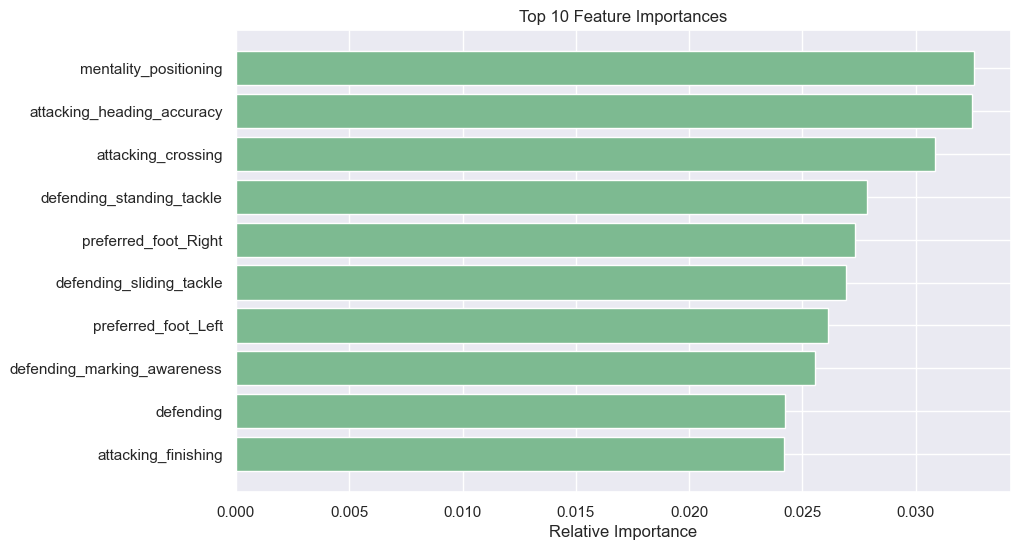

In [38]:
train_test_instance_rf_smote.plot_feature_importance()

Try the models without SMOTE

In [39]:
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [20, 100]
    }

train_test_instance_rf = TrainTestModel(df_train, target='position', model=model_rf, param_grid=param_grid, feature_lists=feature_lists, apply_smote=False)
results_rf = train_test_instance_rf.preprocess_and_train()

In [40]:
print('---------------------------------------------------------------------------------------------')
print('------ Comparission between the different combinations of features using Random Forest ------')
print('---------------------------------------------------------------------------------------------')
results_rf

---------------------------------------------------------------------------------------------
------ Comparission between the different combinations of features using Random Forest ------
---------------------------------------------------------------------------------------------


feature_list  f1_score_weighted  \
0   [goalkeeping_average, defense_average, attacki...           0.298925   
1   [height_cm, weight_kg, body_type, physic, pref...           0.366569   
2   [power_stamina, power_long_shots, power_shot_p...           0.388613   
3   [power_stamina, height_cm, weight_kg, shooting...           0.378202   
4   [overall, potential, value_eur, wage_eur, heig...           0.403570   
5   [overall, potential, value_eur, wage_eur, heig...           0.384760   
6   [overall, height_cm, weight_kg, nationality_na...           0.389162   
7   [defense_average, attacking_average, mentality...           0.288734   
8   [defense_average, attacking_average, mentality...           0.376908   
9   [height_cm, weight_kg, preferred_foot, weak_fo...           0.383855   
10  [overall, potential, height_cm, weight_kg, pre...           0.393513   
11  [height_cm, weight_kg, preferred_foot, weak_fo...           0.398056   
12  [overall, potential, value_eur, wage_eur, heig...           0.402047   
13  [overall, potential, value_eur, wage_eur, heig...           0.318850   

                                           best_model  \
0   (ColumnTransformer(transformers=[('num',\n    ...   
1   (ColumnTransformer(transformers=[('num',\n    ...   
2   (ColumnTransformer(transformers=[('num',\n    ...   
3   (ColumnTransformer(transformers=[('num',\n    ...   
4   (ColumnTransformer(transformers=[('num',\n    ...   
5   (ColumnTransformer(transformers=[('num',\n    ...   
6   (ColumnTransformer(transformers=[('num',\n    ...   
7   (ColumnTransformer(transformers=[('num',\n    ...   
8   (ColumnTransformer(transformers=[('num',\n    ...   
9   (ColumnTransformer(transformers=[('num',\n    ...   
10  (ColumnTransformer(transformers=[('num',\n    ...   
11  (ColumnTransformer(transformers=[('num',\n    ...   
12  (ColumnTransformer(transformers=[('num',\n    ...   
13  (ColumnTransformer(transformers=[('num',\n    ...   

                                          best_params  \
0   {'classifier__max_depth': 20, 'classifier__min...   
1   {'classifier__max_depth': 30, 'classifier__min...   
2   {'classifier__max_depth': 30, 'classifier__min...   
3   {'classifier__max_depth': 20, 'classifier__min...   
4   {'classifier__max_depth': 20, 'classifier__min...   
5   {'classifier__max_depth': 30, 'classifier__min...   
6   {'classifier__max_depth': 20, 'classifier__min...   
7   {'classifier__max_depth': 20, 'classifier__min...   
8   {'classifier__max_depth': 20, 'classifier__min...   
9   {'classifier__max_depth': 30, 'classifier__min...   
10  {'classifier__max_depth': 30, 'classifier__min...   
11  {'classifier__max_depth': 30, 'classifier__min...   
12  {'classifier__max_depth': 20, 'classifier__min...   
13  {'classifier__max_depth': 20, 'classifier__min...   

                                classification_report  
0   {'CAM': {'precision': 0.22058823529411764, 're...  
1   {'CAM': {'precision': 0.2647058823529412, 'rec...  
2   {'CAM': {'precision': 0.3333333333333333, 'rec...  
3   {'CAM': {'precision': 0.16, 'recall': 0.150943...  
4   {'CAM': {'precision': 0.24, 'recall': 0.339622...  
5   {'CAM': {'precision': 0.25, 'recall': 0.358490...  
6   {'CAM': {'precision': 0.25316455696202533, 're...  
7   {'CAM': {'precision': 0.23958333333333334, 're...  
8   {'CAM': {'precision': 0.23376623376623376, 're...  
9   {'CAM': {'precision': 0.2463768115942029, 'rec...  
10  {'CAM': {'precision': 0.2465753424657534, 'rec...  
11  {'CAM': {'precision': 0.2441860465116279, 'rec...  
12  {'CAM': {'precision': 0.2261904761904762, 'rec...  
13  {'CAM': {'precision': 0.2391304347826087, 'rec...

In [41]:
print('---------------------------------------------------------------------------------------------')
print('-----------------------Classification Report using Random Forest ----------------------------')
print('---------------------------------------------------------------------------------------------')
print(pd.DataFrame(results_rf['classification_report'][4]).T)

---------------------------------------------------------------------------------------------
-----------------------Classification Report using Random Forest ----------------------------
---------------------------------------------------------------------------------------------
              precision    recall  f1-score      support
CAM            0.240000  0.339623  0.281250    53.000000
CB             0.200000  0.060606  0.093023    33.000000
CDM            0.068182  0.100000  0.081081    30.000000
CM             0.000000  0.000000  0.000000    15.000000
GK             1.000000  1.000000  1.000000   126.000000
LB             0.608696  0.752688  0.673077    93.000000
LCB            0.662162  0.388889  0.490000   126.000000
LCM            0.342857  0.141176  0.200000    85.000000
LDM            0.304348  0.350000  0.325581    40.000000
LF             0.000000  0.000000  0.000000     6.000000
LM             0.214286  0.121622  0.155172    74.000000
LS             0.105263  0.050000 

The best od features ['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


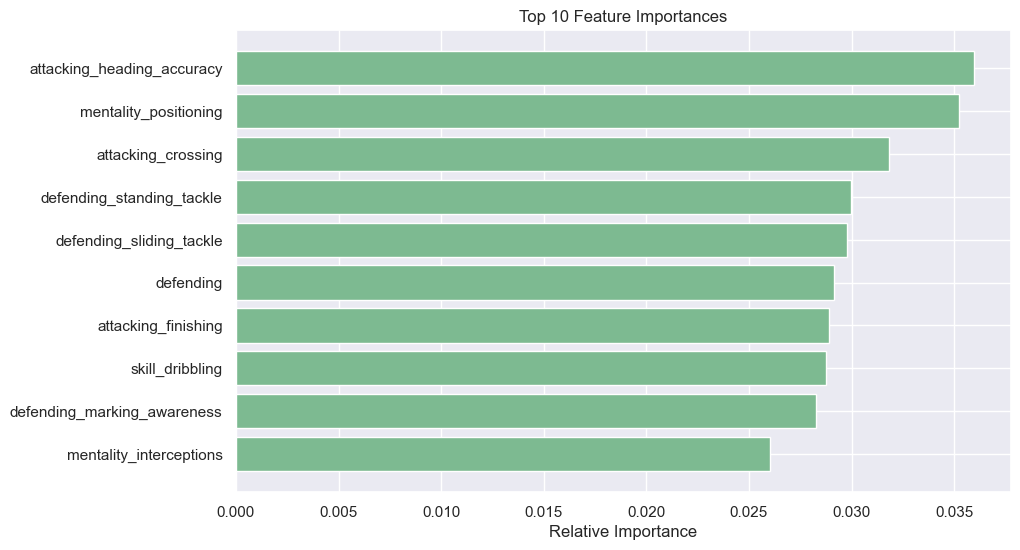

In [42]:
train_test_instance_rf.plot_feature_importance()

# **Model XGBoost**

--- 

`XGBClassifier` uses boosting, specifically gradient boosting. In this process, trees are built sequentially, with each new tree correcting the errors of the previous ones. This is different from bagging methods like RandomForest, where trees are built independently and then averaged. Boosting tends to improve predictive performance by focusing on harder-to-classify instances, but it can be computationally more expensive and slower to train, due to its sequential tree-building process. It is also less parallelizable compared to RandomForest.

- Taking the results form the previous model, we are gonna use the feature list that showed best permormance


In [43]:
model_xgb = XGBClassifier(random_state=42, objective='multi:softmax')

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__colsample_bytree': [0.6, 0.8]}

train_test_instance_xgb = TrainTestModel(df_train, target='position', model=model_xgb, param_grid=param_grid, feature_lists=[features.features_5], apply_smote=True)
results_xgb = train_test_instance_xgb.preprocess_and_train()

In [44]:
print('---------------------------------------------------------------------------------------------')
print('---------------------Classification Report using XGBoost Classifier--------------------------')
print('---------------------------------------------------------------------------------------------')
print(pd.DataFrame(results_xgb['classification_report'][0]).T)

---------------------------------------------------------------------------------------------
---------------------Classification Report using XGBoost Classifier--------------------------
---------------------------------------------------------------------------------------------
              precision    recall  f1-score      support
CAM            0.241935  0.283019  0.260870    53.000000
CB             0.000000  0.000000  0.000000    33.000000
CDM            0.192308  0.166667  0.178571    30.000000
CM             0.000000  0.000000  0.000000    15.000000
GK             1.000000  1.000000  1.000000   126.000000
LB             0.642857  0.774194  0.702439    93.000000
LCB            0.526316  0.476190  0.500000   126.000000
LCM            0.240385  0.294118  0.264550    85.000000
LDM            0.181818  0.100000  0.129032    40.000000
LF             0.000000  0.000000  0.000000     6.000000
LM             0.323529  0.297297  0.309859    74.000000
LS             0.181818  0.100000 

The best od features ['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


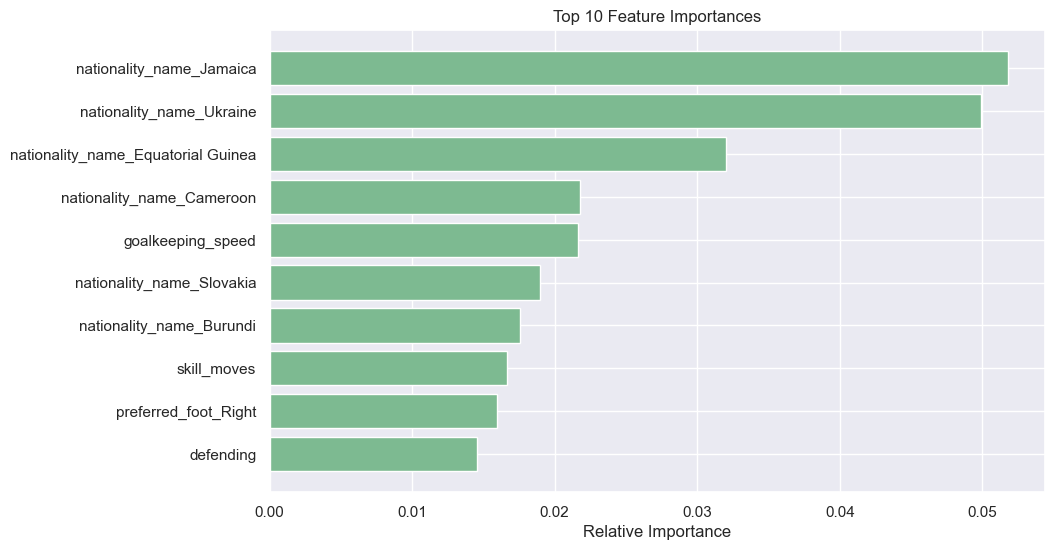

In [45]:
train_test_instance_xgb.plot_feature_importance()

# **Model LGBMClassifier**

`LGBMClassifier` is a gradient boosting framework that leverages decision trees, specifically designed to be fast and efficient. Unlike traditional boosting methods, LightGBM uses a unique approach called Gradient-Based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) to reduce the number of data instances and features, accelerating training without compromising accuracy. It builds trees in a leaf-wise, rather than level-wise, manner, allowing it to focus on growing the most promising branches. This makes LightGBM highly efficient and scalable, especially for large datasets. Additionally, it supports parallel and GPU training, making it faster than many other boosting methods like XGBoost, while maintaining high performance on complex tasks.

---


In [46]:
model = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)

param_grid = {
    'classifier__n_estimators': [100, 200],
    #'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [10, 20],
    'classifier__subsample': [0.5, 0.8],
    'classifier__colsample_bytree': [0.6, 0.8]
    # 'classifier__reg_alpha': [0.1, 0.2, 0.3],
    # #'classifier__reg_lambda': [0.1, 0.2, 0.3],
    #'classifier__boosting_type': ['gbdt', 'dart']
}
train_test_instance_lgbm = TrainTestModel(df=df_train,  target='position',model=model,param_grid=param_grid,feature_lists=[features.features_5], apply_smote=True)
results_lgbm = train_test_instance_lgbm.preprocess_and_train()

In [47]:
print('---------------------------------------------------------------------------------------------')
print('---------------------Classification Report using LGBMClassifier------------------------------')
print('---------------------------------------------------------------------------------------------')
print(pd.DataFrame(results_lgbm['classification_report'][0]).T)

---------------------------------------------------------------------------------------------
---------------------Classification Report using LGBMClassifier------------------------------
---------------------------------------------------------------------------------------------
              precision    recall  f1-score     support
CAM            0.224490  0.207547  0.215686    53.00000
CB             0.250000  0.060606  0.097561    33.00000
CDM            0.181818  0.133333  0.153846    30.00000
CM             0.000000  0.000000  0.000000    15.00000
GK             1.000000  1.000000  1.000000   126.00000
LB             0.631068  0.698925  0.663265    93.00000
LCB            0.529915  0.492063  0.510288   126.00000
LCM            0.227723  0.270588  0.247312    85.00000
LDM            0.166667  0.075000  0.103448    40.00000
LF             0.000000  0.000000  0.000000     6.00000
LM             0.279412  0.256757  0.267606    74.00000
LS             0.125000  0.075000  0.093750   

The best od features ['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


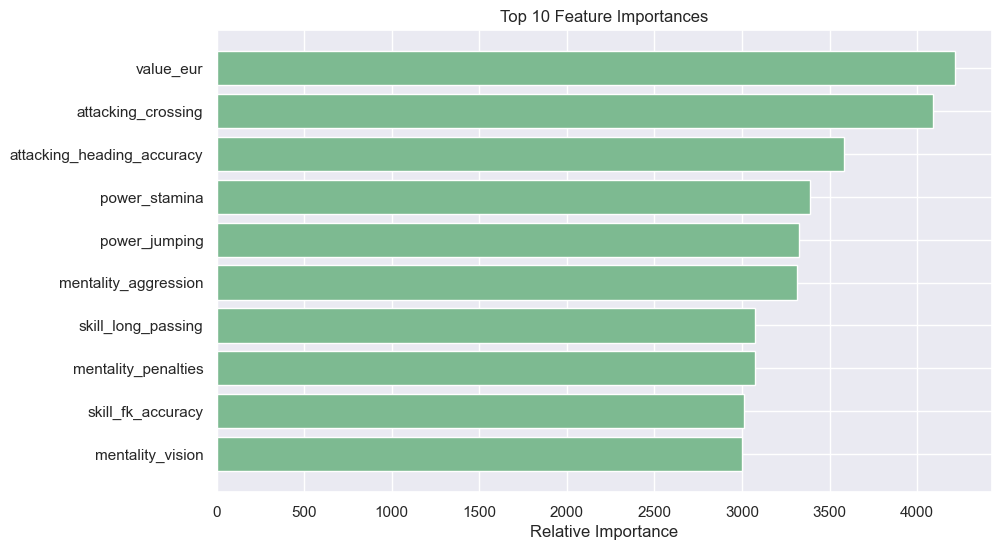

In [48]:
train_test_instance_lgbm.plot_feature_importance()

# **Logistic Regression**
---

In [53]:
model = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1],
    'classifier__solver': ['lbfgs']
    }

train_test_instance_lr = TrainTestModel(df=df_train, target='position', model=model, param_grid=param_grid, feature_lists=[features.features_5], apply_smote=False)

results_lr = train_test_instance_lr.preprocess_and_train()
results_lr

feature_list  f1_score_weighted  \
0  [overall, potential, value_eur, wage_eur, heig...           0.056022   

                                          best_model  \
0  (ColumnTransformer(transformers=[('num',\n    ...   

                                         best_params  \
0  {'classifier__C': 1, 'classifier__penalty': 'l...   

                               classification_report  
0  {'CAM': {'precision': 0.0, 'recall': 0.0, 'f1-...

In [52]:
print('---------------------------------------------------------------------------------------------')
print('---------------------Classification Report using Logistic Regression-------------------------')
print('---------------------------------------------------------------------------------------------')
print(pd.DataFrame(results_lr['classification_report'][0]).T)

---------------------------------------------------------------------------------------------
---------------------Classification Report using Logistic Regression-------------------------
---------------------------------------------------------------------------------------------
              precision    recall  f1-score      support
CAM            0.000000  0.000000  0.000000    53.000000
CB             0.000000  0.000000  0.000000    33.000000
CDM            0.000000  0.000000  0.000000    30.000000
CM             0.000000  0.000000  0.000000    15.000000
GK             0.154321  0.198413  0.173611   126.000000
LB             0.000000  0.000000  0.000000    93.000000
LCB            0.095315  0.468254  0.158389   126.000000
LCM            0.000000  0.000000  0.000000    85.000000
LDM            0.000000  0.000000  0.000000    40.000000
LF             0.000000  0.000000  0.000000     6.000000
LM             0.075145  0.175676  0.105263    74.000000
LS             0.000000  0.000000 

# **Ensamble**

---
We are gonna try 2 strategies:

1. Combine the results of different models. This approach combines the predictions from three individual models: **Random Forest, XGBoost, and LightGBM**. By calculating a weighted average of their predicted probabilities, which is known as soft voting. This ensemble method leverages the strengths of each model while mitigating their individual weaknesses. Producing a more robust and accurate final prediction compared to any single model. 

2. Run a model in stages. First, we predict broader classes by aggregating positions into larger groups. Once these superclass predictions are obtained, they are used as additional features for the final model. This final stage aims to leverage the insights gained from earlier predictions to better separate and differentiate between the more granular target classes. This hierarchical strategy helps the model capture complex relationships, improving overall accuracy and robustness.

#### **1. Weighted Average**

Another alternative is to combine the predictions from different models and calculate the average of their predicted probabilities, a method known as soft voting. 

In this approach, each model's output is treated as a probability distribution across classes, and the final prediction is determined by averaging these probabilities.

Soft voting leverages the strengths of multiple models, reducing the impact of individual model biases or errors. 

By combining diverse perspectives, this method often improves overall performance and increases robustness, especially when the models have complementary strengths.

In [55]:
best_result_rf = max(train_test_instance_rf_smote.results, key=lambda x: x['f1_score_weighted'])
best_model_rf = best_result_rf['best_model']
feature_list_rf = best_result_rf['feature_list']
y_pred_rf = best_model_rf.predict_proba(df_train[feature_list_rf])

best_result_xgb = max(train_test_instance_xgb.results, key=lambda x: x['f1_score_weighted'])
best_model_xgb = best_result_xgb['best_model']
feature_list_xgb = best_result_xgb['feature_list']
y_pred_xgb = best_model_xgb.predict_proba(df_train[feature_list_xgb])

best_result_lgbm = max(train_test_instance_lgbm.results, key=lambda x: x['f1_score_weighted'])
best_model_lgbm = best_result_lgbm['best_model']
feature_list_lgbm = best_result_lgbm['feature_list']
y_pred_lgbm = best_model_lgbm.predict_proba(df_train[feature_list_lgbm])

y_pred = (y_pred_rf +y_pred_xgb +y_pred_lgbm)/3
y_pred = np.argmax(y_pred, axis=1)
y_pred = train_test_instance_rf.encoder.inverse_transform(y_pred)

In [56]:
print(classification_report(df_train.position, y_pred))

              precision    recall  f1-score   support

         CAM       0.85      0.85      0.85       263
          CB       0.96      0.81      0.88       167
         CDM       0.86      0.83      0.84       151
          CM       0.94      0.80      0.86        75
          GK       1.00      1.00      1.00       631
          LB       0.92      0.95      0.93       463
         LCB       0.92      0.90      0.91       631
         LCM       0.83      0.85      0.84       423
         LDM       0.93      0.82      0.87       201
          LF       0.96      0.81      0.88        32
          LM       0.88      0.86      0.87       369
          LS       0.90      0.81      0.85       201
          LW       0.90      0.84      0.87       166
         LWB       0.97      0.82      0.89       104
          RB       0.90      0.96      0.93       463
         RCB       0.87      0.92      0.89       631
         RCM       0.80      0.86      0.83       423
         RDM       0.84    

Iterate over different combinations of weight to ensable the results of the different models

In [57]:
from itertools import product
weights = np.arange(0.0, 1.1, 0.1)
weight_combinations = [(w1, w2, w3) for w1, w2, w3 in product(weights, repeat=3) if np.isclose(w1 + w2 + w3, 1.0)]

best_f1 = 0
best_weights = None
best_pred = None

for w1, w2, w3 in weight_combinations:
    y_pred = (w1 * y_pred_rf + w2 * y_pred_xgb + w3 * y_pred_lgbm)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_pred_class = train_test_instance_rf.encoder.inverse_transform(y_pred_class)
    
    f1 = f1_score(df_train.position, y_pred_class, average='weighted')
    
    if f1 > best_f1:
        best_f1 = f1
        best_weights = (w1, w2, w3)
        best_pred = y_pred_class

print(f"Best weights: {best_weights}, Best F1 score: {best_f1}")

Best weights: (0.7000000000000001, 0.30000000000000004, 0.0), Best F1 score: 0.8896991990605371


 The weights assigned to each model reflect their relative importance, with the optimal combination of:

- 0.7 for Random Forest
- 0.3 for XGBoost
- 0.0 for LightGBM

Determined through different tries to maximize the weighted f1 score.

Notice that this score is calculated on the training dataset, not in the testing dataset, which we expect will be less.

In [58]:
print(classification_report(df_train.position, best_pred))

              precision    recall  f1-score   support

         CAM       0.80      0.87      0.84       263
          CB       0.97      0.81      0.88       167
         CDM       0.81      0.84      0.82       151
          CM       0.94      0.80      0.86        75
          GK       1.00      1.00      1.00       631
          LB       0.91      0.95      0.93       463
         LCB       0.93      0.89      0.91       631
         LCM       0.85      0.85      0.85       423
         LDM       0.88      0.82      0.85       201
          LF       0.96      0.81      0.88        32
          LM       0.88      0.85      0.87       369
          LS       0.90      0.81      0.85       201
          LW       0.88      0.83      0.85       166
         LWB       0.98      0.81      0.88       104
          RB       0.90      0.97      0.93       463
         RCB       0.87      0.94      0.90       631
         RCM       0.84      0.85      0.85       423
         RDM       0.83    

#### **2. Ensamble - Stages**

**1.First Stage**

In [59]:
model_xgb = XGBClassifier(random_state=42, objective='multi:softmax')
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__colsample_bytree': [0.6, 0.8]
}
train_test_instance_xgb_subposition = TrainTestModel(df_train, target='subposition', model=model_xgb, param_grid=param_grid, feature_lists=feature_lists, apply_smote=True)
results_xgb_subposition = train_test_instance_xgb_subposition.preprocess_and_train()
results_xgb_subposition

feature_list  f1_score_weighted  \
0   [goalkeeping_average, defense_average, attacki...           0.784436   
1   [height_cm, weight_kg, body_type, physic, pref...           0.807695   
2   [power_stamina, power_long_shots, power_shot_p...           0.837035   
3   [power_stamina, height_cm, weight_kg, shooting...           0.821229   
4   [overall, potential, value_eur, wage_eur, heig...           0.859106   
5   [overall, potential, value_eur, wage_eur, heig...           0.848975   
6   [overall, height_cm, weight_kg, nationality_na...           0.862108   
7   [defense_average, attacking_average, mentality...           0.769995   
8   [defense_average, attacking_average, mentality...           0.824931   
9   [height_cm, weight_kg, preferred_foot, weak_fo...           0.851351   
10  [overall, potential, height_cm, weight_kg, pre...           0.849700   
11  [height_cm, weight_kg, preferred_foot, weak_fo...           0.856418   
12  [overall, potential, value_eur, wage_eur, heig...           0.863685   
13  [overall, potential, value_eur, wage_eur, heig...           0.848463   

                                           best_model  \
0   (ColumnTransformer(transformers=[('num',\n    ...   
1   (ColumnTransformer(transformers=[('num',\n    ...   
2   (ColumnTransformer(transformers=[('num',\n    ...   
3   (ColumnTransformer(transformers=[('num',\n    ...   
4   (ColumnTransformer(transformers=[('num',\n    ...   
5   (ColumnTransformer(transformers=[('num',\n    ...   
6   (ColumnTransformer(transformers=[('num',\n    ...   
7   (ColumnTransformer(transformers=[('num',\n    ...   
8   (ColumnTransformer(transformers=[('num',\n    ...   
9   (ColumnTransformer(transformers=[('num',\n    ...   
10  (ColumnTransformer(transformers=[('num',\n    ...   
11  (ColumnTransformer(transformers=[('num',\n    ...   
12  (ColumnTransformer(transformers=[('num',\n    ...   
13  (ColumnTransformer(transformers=[('num',\n    ...   

                                          best_params  \
0   {'classifier__colsample_bytree': 0.6, 'classif...   
1   {'classifier__colsample_bytree': 0.8, 'classif...   
2   {'classifier__colsample_bytree': 0.8, 'classif...   
3   {'classifier__colsample_bytree': 0.8, 'classif...   
4   {'classifier__colsample_bytree': 0.6, 'classif...   
5   {'classifier__colsample_bytree': 0.8, 'classif...   
6   {'classifier__colsample_bytree': 0.6, 'classif...   
7   {'classifier__colsample_bytree': 0.8, 'classif...   
8   {'classifier__colsample_bytree': 0.8, 'classif...   
9   {'classifier__colsample_bytree': 0.6, 'classif...   
10  {'classifier__colsample_bytree': 0.6, 'classif...   
11  {'classifier__colsample_bytree': 0.6, 'classif...   
12  {'classifier__colsample_bytree': 0.6, 'classif...   
13  {'classifier__colsample_bytree': 0.6, 'classif...   

                                classification_report  
0   {'attack': {'precision': 0.717948717948718, 'r...  
1   {'attack': {'precision': 0.7478991596638656, '...  
2   {'attack': {'precision': 0.7641921397379913, '...  
3   {'attack': {'precision': 0.7489539748953975, '...  
4   {'attack': {'precision': 0.7811158798283262, '...  
5   {'attack': {'precision': 0.7533039647577092, '...  
6   {'attack': {'precision': 0.8026905829596412, '...  
7   {'attack': {'precision': 0.7022058823529411, '...  
8   {'attack': {'precision': 0.7510204081632653, '...  
9   {'attack': {'precision': 0.7666666666666667, '...  
10  {'attack': {'precision': 0.7575757575757576, '...  
11  {'attack': {'precision': 0.7591836734693878, '...  
12  {'attack': {'precision': 0.7896995708154506, '...  
13  {'attack': {'precision': 0.7258064516129032, '...

In [92]:
model_1_subposition = max(train_test_instance_xgb_subposition.results, key=lambda x: x['f1_score_weighted'])
model_1_subposition = model_1_subposition['best_model']
pred_subpos = model_1_subposition.predict(df_train[features.features_13])
predictions_labels_sub = train_test_instance_xgb_subposition.encoder.inverse_transform(pred_subpos)
df_train['subposition_pred'] = predictions_labels_sub

final_features = features.features_13.copy()
final_features.append('subposition_pred')

##### **2.Second Stage**

In [93]:
train_test_instance_xgb_position = TrainTestModel(df_train, target='position', model=model_xgb, param_grid=param_grid, feature_lists=[final_features], apply_smote=True)
results_xgb_position = train_test_instance_xgb_position.preprocess_and_train()
results_xgb_position

feature_list  f1_score_weighted  \
0  [overall, potential, value_eur, wage_eur, heig...           0.438507   

                                          best_model  \
0  (ColumnTransformer(transformers=[('num',\n    ...   

                                         best_params  \
0  {'classifier__colsample_bytree': 0.8, 'classif...   

                               classification_report  
0  {'CAM': {'precision': 0.2857142857142857, 'rec...

In [106]:
print('---------------------------------------------------------------------------------------------')
print('---------------------Classification Report using Ensemble Stages-------------------------')
print('---------------------------------------------------------------------------------------------')
print(pd.DataFrame(results_xgb_position['classification_report'][0]).T)

---------------------------------------------------------------------------------------------
---------------------Classification Report using Ensemble Stages-------------------------
---------------------------------------------------------------------------------------------
              precision    recall  f1-score      support
CAM            0.285714  0.301887  0.293578    53.000000
CB             0.125000  0.030303  0.048780    33.000000
CDM            0.037037  0.033333  0.035088    30.000000
CM             0.000000  0.000000  0.000000    15.000000
GK             1.000000  1.000000  1.000000   126.000000
LB             0.755102  0.795699  0.774869    93.000000
LCB            0.504132  0.484127  0.493927   126.000000
LCM            0.235849  0.294118  0.261780    85.000000
LDM            0.250000  0.225000  0.236842    40.000000
LF             0.000000  0.000000  0.000000     6.000000
LM             0.432836  0.391892  0.411348    74.000000
LS             0.090909  0.075000  0.0

# **Predictions**
----

#### **Quick EDA on the testing dataset**


This section aims to assess whether the testing data exhibits similar patterns and behaviors to those observed during training. 

By exploring this, we can gain an initial intuition about the model's expected performance and its ability to generalize effectively to unseen data.


In [95]:
def preprocess():
    df_test = pd.read_csv('test.csv')

    functions_feature_creation = [age, experience, create_continent, skills_average]

    for i in functions_feature_creation:
        df_test = i(df_test)

    columns_to_drop=['club_jersey_number','short_name', 'club_joined', 'club_loaned_from', 'nation_jersey_number',
            'release_clause_eur', 'player_tags', 'player_traits', 'real_face', 'birthday_date', 'club_contract_valid_until']

    def drop_columns(df, columns):
        for col in columns:
            if col in df.columns:
                df = df.drop(columns=[col])
            else:
                print(f"The column '{col}' does not exist in df")
        return df

    df_test = drop_columns(df_test, columns_to_drop)
    return df_test

In [96]:
df_test = preprocess()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           767 non-null    int64  
 1   overall                      767 non-null    int64  
 2   potential                    767 non-null    int64  
 3   value_eur                    764 non-null    float64
 4   wage_eur                     767 non-null    int64  
 5   height_cm                    767 non-null    int64  
 6   weight_kg                    767 non-null    int64  
 7   club_name                    767 non-null    object 
 8   league_name                  767 non-null    object 
 9   league_level                 767 non-null    int64  
 10  nationality_name             767 non-null    object 
 11  preferred_foot               767 non-null    object 
 12  weak_foot                    767 non-null    int64  
 13  skill_moves         

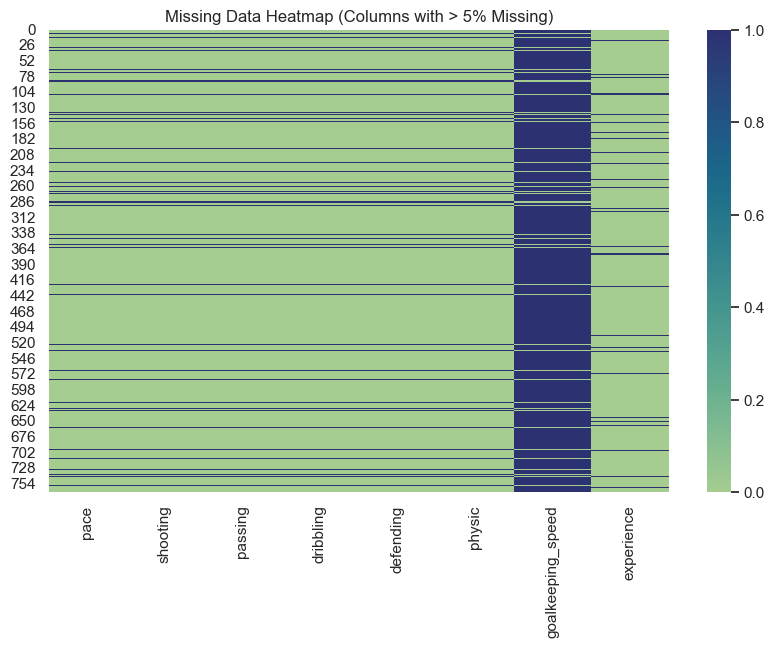

In [97]:
missing_percentage = df_test.isnull().mean() * 100
columns_above_threshold = missing_percentage[missing_percentage > 5].index
plt.figure(figsize=(10, 6))
sns.heatmap(df_test[columns_above_threshold].isnull(), cbar=True, cmap="crest")
plt.title('Missing Data Heatmap (Columns with > 5% Missing)')
plt.show()

The feature with the most significant amount of missing data is `goalkeeping_speed`.

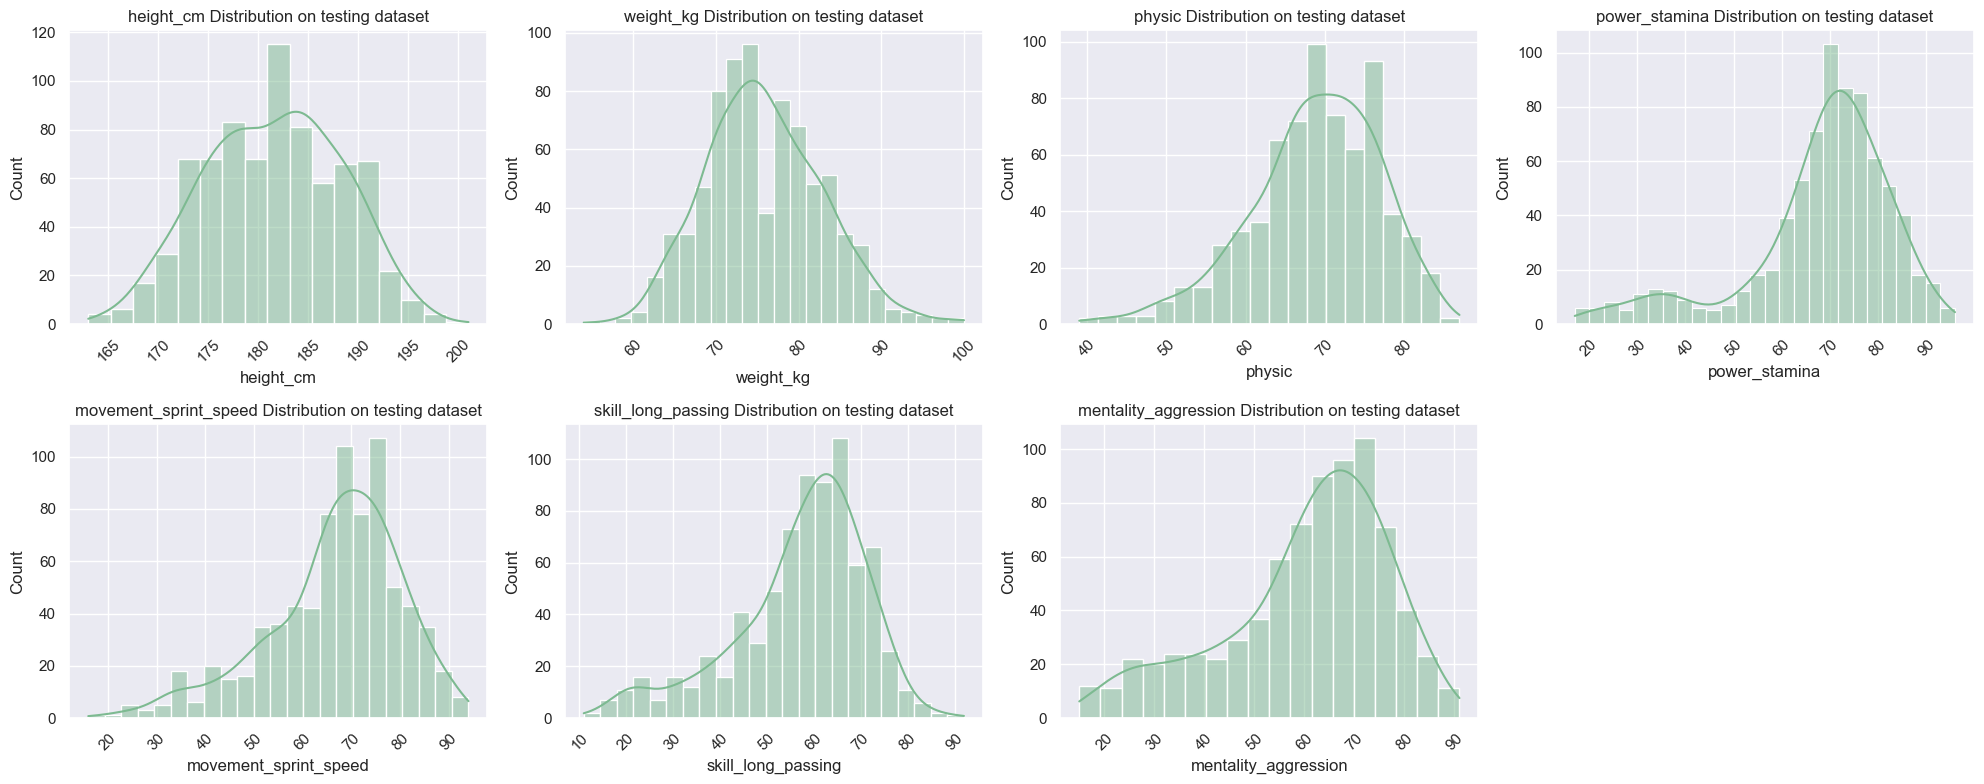

In [98]:
violin_features = ['height_cm', 'weight_kg', 'physic', 'power_stamina','movement_sprint_speed','skill_long_passing', 'mentality_aggression']
plt.figure(figsize=(20, 8))
for i, feature in enumerate(violin_features, 1):
    plt.subplot(2, 4, i)
    sns.histplot(x=feature, data=df_test, kde=True, palette="crest", common_norm=True)
    plt.title(f'{feature} Distribution on testing dataset')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



- The distribution patterns in the test set appear consistent with those observed in the training set. Features like `height_cm` and `weight_kg` exhibit normal or near-normal distributions, while others like `physic`, `power_stamina`, `movement_sprint_speed`, `skill_long_passing` and `mentality_aggression` appear to be skewed.
 
    - This can be partly explained due that players have different physical and skill requirements depending on their role. For example, forwards prioritize speed, midfielders  prioritize passing, and defenders prioritize aggression. The most noticeble skewness in variables like `power_stamina` and `skill_long_passing` reflects the diversity of roles in the dataset.

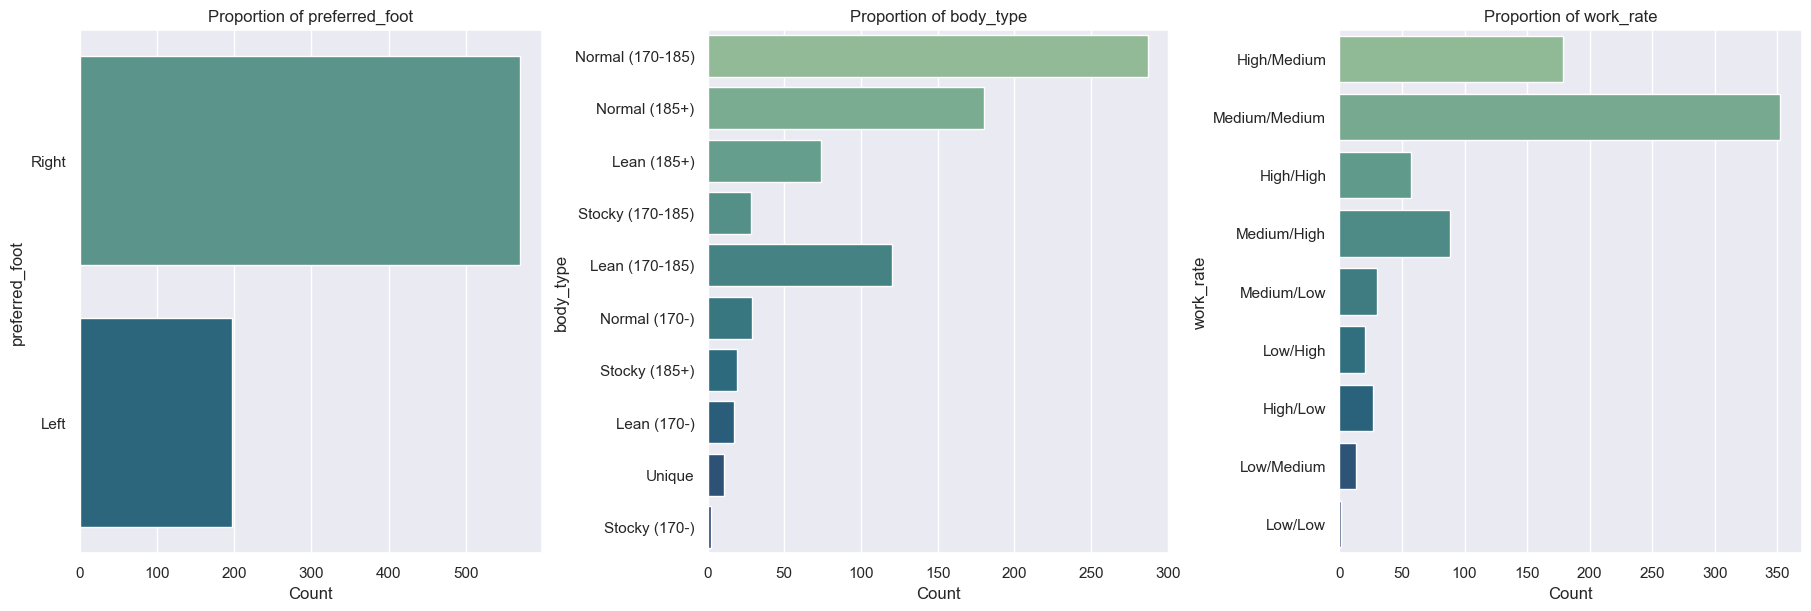

In [99]:
categorical_features = ['preferred_foot', 'body_type', 'work_rate']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
for ax, feature in zip(axes, categorical_features):
    sns.countplot(y=feature, data=df_test, palette='crest', ax=ax)
    ax.set_title(f'Proportion of {feature}')
    ax.set_xlabel('Count')
    ax.set_ylabel(feature)
plt.show()

- Preferred Foot: From the plot on the left, we see that the majority of players prefer their right foot, with a significantly smaller proportion favoring their left. This distribution is consistent with general player demographics, where right-footed players dominate. 

- Body Type: In the middle plot, the majority of players fall into the "Normal (170-185)" category, followed by "Normal (185+)" and "Lean (185+)." This suggests that normal body types are predominant across most positions. Players in the "Stocky" categories (both height groups) are relatively fewer, which is expected as these body types are typically associated with specialized roles like defenders or goalkeepers. The "Unique" body type has an even smaller representation, likely corresponding to outlier roles or player profiles.

- Work Rate: In the rightmost plot, the largest proportion of players have a "Medium/Medium" work rate, highlighting balanced contributions in both attacking and defensive play. Other combinations, such as "High/Medium" and "High/High," are also prevalent but to a lesser extent, likely reflecting players in more specialized roles such as forwards or midfielders. The less common work rates such as "Low/Low," "High/Low" show that these playstyles are less frequent and may correspond to niche positions or roles on the field.


In [100]:
def predict(df_test, trained_model_instance, output_file):

    best_result = max(trained_model_instance.results, key=lambda x: x['f1_score_weighted'])
    best_model = best_result['best_model']
    feature_list = best_result['feature_list']
    print(feature_list)

    X_test = df_test[feature_list]
    predictions = best_model.predict(X_test)
    predictions_labels = trained_model_instance.encoder.inverse_transform(predictions)
    predictions_df = pd.DataFrame({
        'id': df_test['id'],
        'predictions': predictions_labels
    })
    predictions_df.to_csv(f'{output_file}.csv', index=False)
    return 

**Predictions Random Forest**

In [107]:
predict(df_test,train_test_instance_rf_smote, 'predictions_rf_smote')

['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


**Predictions XGBoost**

In [108]:
predict(df_test,train_test_instance_xgb, 'predictions_xgb')

['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


**Predictions LBGM**

In [109]:
predict(df_test,train_test_instance_lgbm, 'predictions_lgbm')

['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


**Predictions LogisticRegression**

In [110]:
predict(df_test,train_test_instance_lr, 'predictions_lr')

['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_speed']


**Predictions Ensemble - Soft Voting**

In [112]:
best_result_rf = max(train_test_instance_rf.results, key=lambda x: x['f1_score_weighted'])
best_model_rf = best_result_rf['best_model']
feature_list_rf = best_result_rf['feature_list']
y_pred_rf = best_model_rf.predict_proba(df_test[feature_list_rf])

best_result_xgb = max(train_test_instance_xgb.results, key=lambda x: x['f1_score_weighted'])
best_model_xgb = best_result_xgb['best_model']
feature_list_xgb = best_result_xgb['feature_list']
y_pred_xgb = best_model_xgb.predict_proba(df_test[feature_list_xgb])

best_result_lgbm = max(train_test_instance_lgbm.results, key=lambda x: x['f1_score_weighted'])
best_model_lgbm = best_result_lgbm['best_model']
feature_list_lgbm = best_result_lgbm['feature_list']
y_pred_lgbm = best_model_lgbm.predict_proba(df_test[feature_list_lgbm])

y_pred = (y_pred_rf * best_weights[0] + y_pred_xgb * best_weights[1] + y_pred_lgbm * best_weights[2])
y_pred = np.argmax(y_pred, axis=1)
y_pred = train_test_instance_rf.encoder.inverse_transform(y_pred)

df_test['predictions'] = y_pred
df_test[['id', 'predictions']].to_csv('predictions_ensemble_weighted.csv', index=False)


**Predictions Ensemble - Steps**

In [114]:
model_1_subposition = max(train_test_instance_xgb_subposition.results, key=lambda x: x['f1_score_weighted'])
model_1_subposition = model_1_subposition['best_model']
pred_subpos = model_1_subposition.predict(df_test[features.features_13])
predictions_labels_sub = train_test_instance_xgb_subposition.encoder.inverse_transform(pred_subpos)
df_test['subposition_pred'] = predictions_labels_sub
predict(df_test, train_test_instance_xgb_position, 'predictions_ensemble_steps.csv')

['overall', 'potential', 'value_eur', 'wage_eur', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'nationality_name', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'age', 'experience', 'continent', 'su

# **Conclusions**
---

### Challenges, and model choice:
Predicting 24 player positions is a challenging multi-class classification problem due to the large number of categories, overlapping attributes between positions such as for example in midfielders and wingers, and potential data imbalances. Attributes like `height`, `speed`, and `skill` ratings often interact in non-linear ways, making it difficult for a linear model to capture these complex relationships. Decision tree models are better suited for this task because they naturally handle non-linear interactions and create intuitive rule-based splits. Unlike linear models, which assume straight-line relationships. 

### Best model obtained and final score:

- In this case **f1 score** metric is particularly useful because the data has class imbalance, meaning there is an uneven distribution of observations across the 24 position. This imbalance can make other metrics, such as accuracy, misleading, as they tend to favor the majority classes while neglecting the performance on minority ones. 

- Based on the results from the Kaggle Submission, the highest F1 score was achieved using a XGBoost model using SMOTE as balancing techinque, where the features used to generate the predictions were the ones from the list `features_5`.

- The model performs best at predicting positions such as Goalkeeper (GK), with perfect precision, recall, and F1-score, indicating it reliably identifies all instances of this class. Other positions with relatively strong performance include Left Back (LB), Right Back (RB), Right Center Back (RCB), and Striker (ST), where F1-scores range between 0.56 and 0.70. These results suggest the model is adept at predicting defensive and central attacking roles with higher support counts. However, the model struggles significantly with positions such as Center Midfielder (CM), Left Forward (LF), and Right Forward (RF), where F1-scores are effectively 0, indicating that these classes are either misclassified or not predicted at all. 

- Examining the feature importance reveals that some nationalities appear to be relatively significant in generating predictions. Additionally, the goalkeeping_speed attribute, which we identified as being exclusive to the goalkeeper class, plays a crucial role. This feature enables the model to accurately distinguish goalkeepers from other positions.



----------------

- What business insight can er get about this model?
- Limitations

----------